# Прогнозирование оттока Клиентов для Компании «ТелеДом»

Текущее исследование проводится в интересах оператора связи «ТелеДом».
Работа направлена на борьбу с оттоком клиентов. Для этого сотрудники Компании начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.

**Цель исследования:** построить модель, которая определит, разорвет ли клиент договор, исходя из:
* персональных данных Клиента
* информации о заключенных Контрактах
* подключенных тарифах и услугах

**Ограничения исследования:**
1. Значение ROC-AUC на тестовой среде должна быть не менее 0.85
2. Размер тестовой выборки -- 25% от общего объема
3. Фиксированный RAND_FIX = 150324
4. В данных нет зависимости от времени
5. Заказчик не выставил нефункциональных требований. Ограничения на время обучения и предсказания модели отсутствуют.

**Ход исследования:**  
Наше исследование будет проходить в восемь этапов:  
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

При необходимости состав разделов может быть изменен.


**Описание данных**  

* **contract_new.csv** — информация о договоре
    - **customerID** — идентификатор абонента
    - **BeginDate** — дата начала действия договора
    - **EndDate** — дата окончания действия договора
    - **Type** — тип оплаты: раз в год-два или ежемесячно
    - **PaperlessBilling** — электронный расчётный лист
    - **PaymentMethod** — тип платежа
    - **MonthlyCharges** — расходы за месяц
    - **TotalCharges** — общие расходы абонента
    
* **personal_new.csv** — персональные данные клиента
    - **customerID** — идентификатор пользователя
    - **gender** — пол
    - **SeniorCitizen** — является ли абонент пенсионером
    - **Partner** — есть ли у абонента супруг или супруга
    - **Dependents** — есть ли у абонента дети
    
* **internet_new.csv** — информация об интернет-услугах
    - **customerID** — идентификатор пользователя
    - **InternetService** — тип подключения
    - **OnlineSecurity** — блокировка опасных сайтов
    - **OnlineBackup** — облачное хранилище файлов для резервного копирования данных
    - **DeviceProtection** — антивирус
    - **TechSupport** — выделенная линия технической поддержки
    - **StreamingTV** — стриминговое телевидение
    - **StreamingMovies** — каталог фильмов
    
* phone_new.csv — информация об услугах телефонии
    - **customerID** — идентификатор пользователя
    - **MultipleLines** — подключение телефона к нескольким линиям одновременно
    
    
_______________________

Для начала импортируем библиотеки и зафиксируем глобальные константы:

In [1]:
# ! pip install -Uq scikit-learn   # обновите версию, плз, без этого ColumnTransformer толком не заработает
# ! pip install phik -q   # phik тоже не хватает на Тренажере
# ! pip install catboost

In [2]:
# ! pip install lightgbm

In [3]:
# Основа
import pandas as pd
import numpy as np
import re 
import warnings 

# Графики
import seaborn as sns 
import matplotlib.pyplot as plt

# Мультиколлениарность
from phik.report import plot_correlation_matrix
from phik import report

# Подготовка данных к обучению моделей
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

# Модели, обучение и гиперпараметры
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

# Метрики и результирующие графики
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
warnings.filterwarnings('ignore') # отключаем предупреждения

In [5]:
# Общие константы:
MODE = '' 
MODE = 'check' 
# Константа-рычаг для проверки работы. Включает оптимальные гиперпараметры для моделей и выключает логирование. 
# Если закомментить, то будет включен перерасчет. 
# MODE = 'check' -- включено.
# Всё остальное -- выключено.

RAND_FIX = 150324

In [6]:
%%javascript
// Костыль для того, чтоб не сворачивалось окно при длинном выводе
IPython.OutputArea.auto_scroll_threshold = 150; 

<IPython.core.display.Javascript object>

## Шаг 1 Загрузка данных

### 1.1 Формирование датафреймов и первый взгляд на них

Загрузим данные, посмотрим также на распределение категориальных переменных

In [7]:
try:
    d_contract = pd.read_csv('datasets/contract_new.csv', sep=',')
    d_personal = pd.read_csv('datasets/personal_new.csv', sep=',')
    d_internet = pd.read_csv('datasets/internet_new.csv', sep=',')
    d_phone = pd.read_csv('datasets/phone_new.csv', sep=',')
    
    labels = ['contract_new.csv - информация о договоре', 'personal_new.csv - персональные данные клиента', \
              'internet_new.csv - информация об интернет-услугах', 'phone_new.csv - информация об услугах телефонии']
    
    l_df = [d_contract, d_personal, d_internet, d_phone]
    
    for i in range(4):
        print('*' * 50, labels[i], sep='\n')
        display(l_df[i].head(5))
        print()
        l_df[i].info()
        print('\n'*2)
        
    del labels
    
except:
    d_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv', sep=',') 
    d_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv', sep=',')
    d_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv', sep=',')
    d_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv', sep=',')
    
    labels = ['contract_new.csv - информация о договоре', 'personal_new.csv - персональные данные клиента', \
              'internet_new.csv - информация об интернет-услугах', 'phone_new.csv - информация об услугах телефонии']
    
    l_df = [d_contract, d_personal, d_internet, d_phone]
    
    for i in range(4):
        print('*' * 50, labels[i], sep='\n')
        display(l_df[i].head(5))
        print()
        l_df[i].info()
        print('\n'*2)
        
    del labels

**************************************************
contract_new.csv - информация о договоре


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB



**************************************************
personal_new.csv - персональные данные клиента


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB



**************************************************
internet_new.csv - информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB



**************************************************
phone_new.csv - информация об услугах телефонии


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB





In [8]:
print('Количество дублей во всех таблицах по полю "customerID" равно', \
      d_contract['customerID'].duplicated().sum() + \
      d_personal['customerID'].duplicated().sum() + \
      d_internet['customerID'].duplicated().sum() + \
      d_phone['customerID'].duplicated().sum())

Количество дублей во всех таблицах по полю "customerID" равно 0


* Пропусков явных нет
* Видно, что не все пользователи подключили телефон или интернет
* Нужно будет поправить наименования столбцов
* Нужно будет поработать с типами
* Явных дубликатов нет

### 1.2 Распределение категориальных признаков

Признаки d_contract с данными о Контрактах

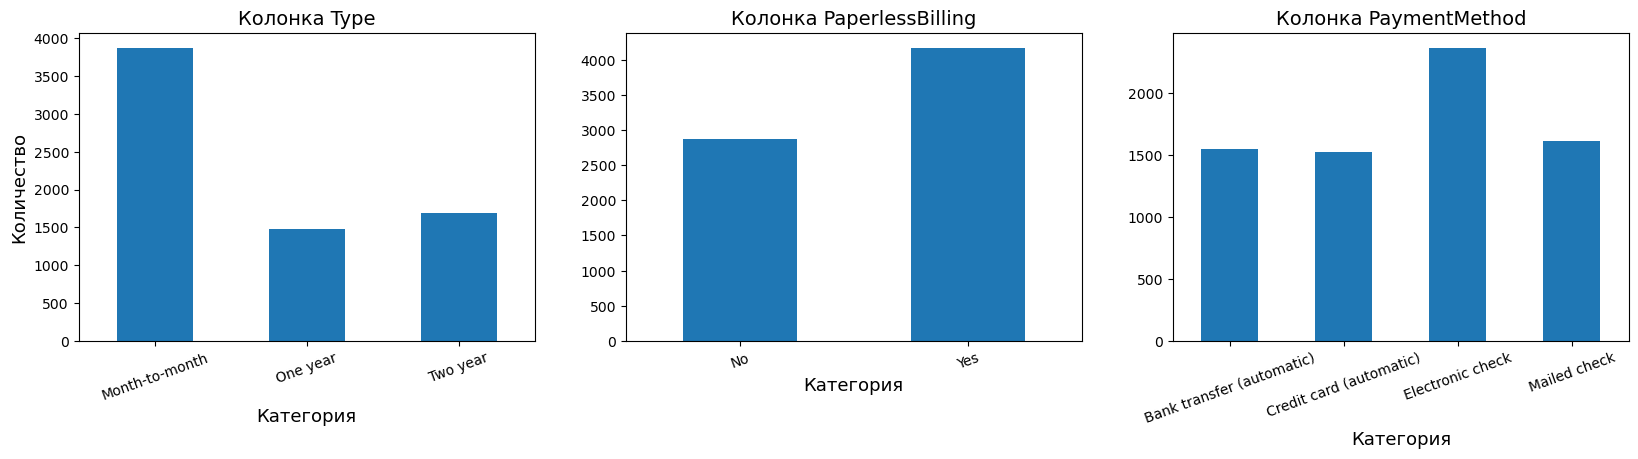

In [9]:
contract_cat_l = ['Type', 'PaperlessBilling', 'PaymentMethod']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].set_ylabel('Количество', fontsize=13)
for i in range(3):
    d_contract.groupby(contract_cat_l[i])[contract_cat_l[i]].count().plot(kind='bar', ax = ax[i])
    ax[i].set_title('Колонка ' + contract_cat_l[i], fontsize=14)
    ax[i].set_xlabel('Категория', fontsize=13)
    ax[i].tick_params(axis='x', labelrotation = 20)

Признаки d_personal с персональными данными Клиентов

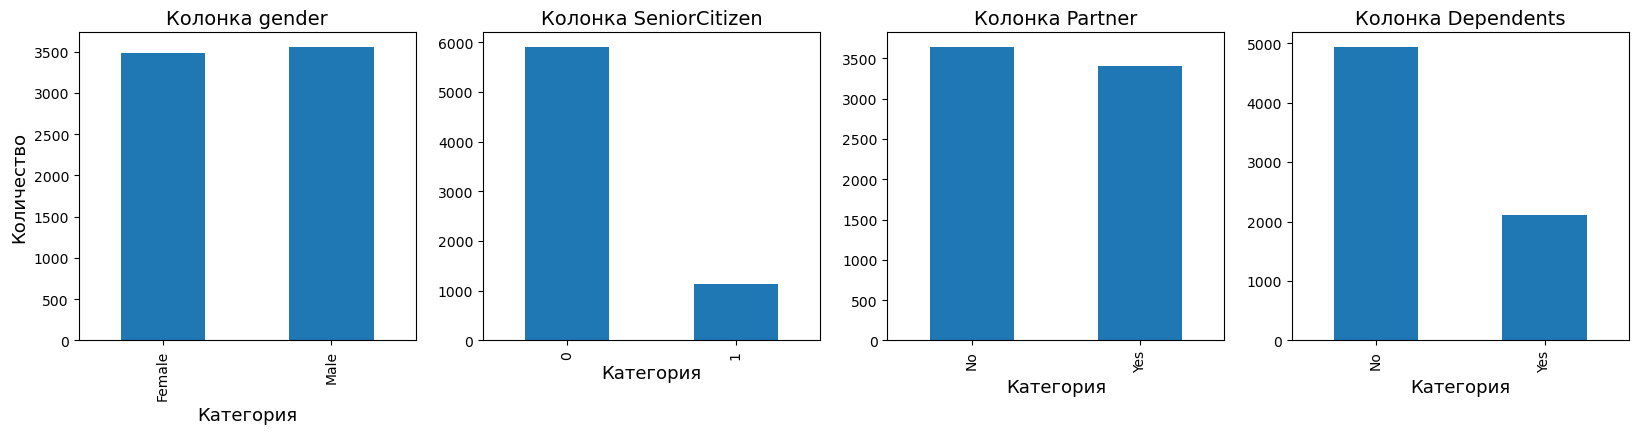

In [10]:
personal_cat_l = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
ax[0].set_ylabel('Количество', fontsize=13)
for i in range(4):
    d_personal.groupby(personal_cat_l[i])[personal_cat_l[i]].count().plot(kind='bar', ax = ax[i])
    ax[i].set_title('Колонка ' + personal_cat_l[i], fontsize=14)
    ax[i].set_xlabel('Категория', fontsize=13)

Признаки d_internet с данными о подключенных интернет-услугах

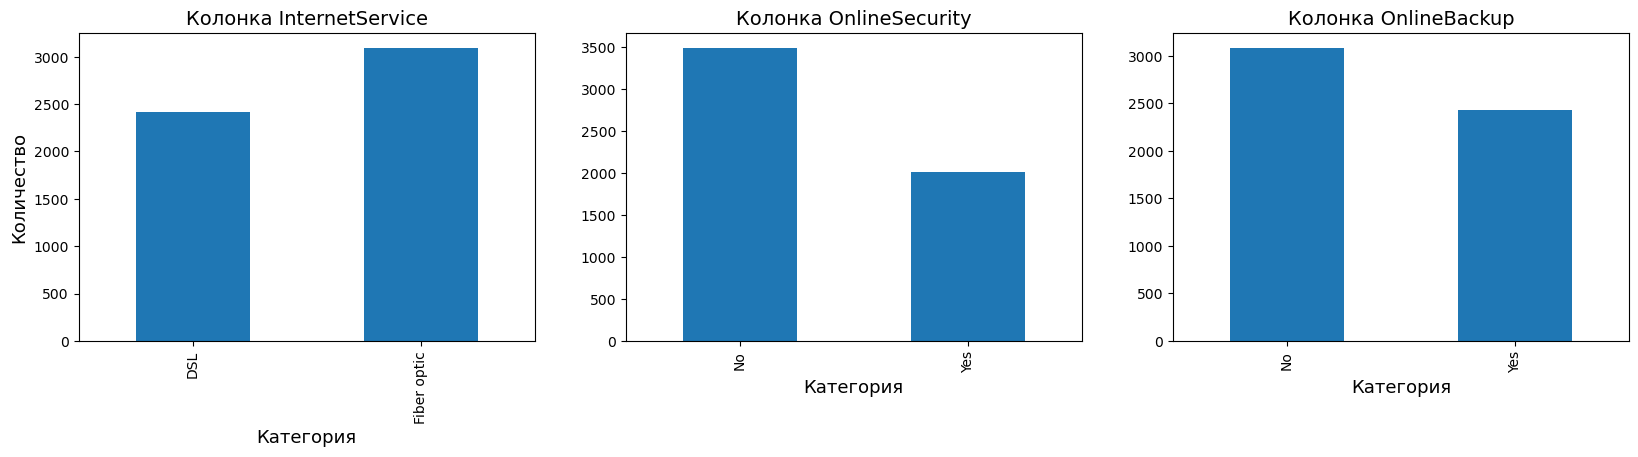

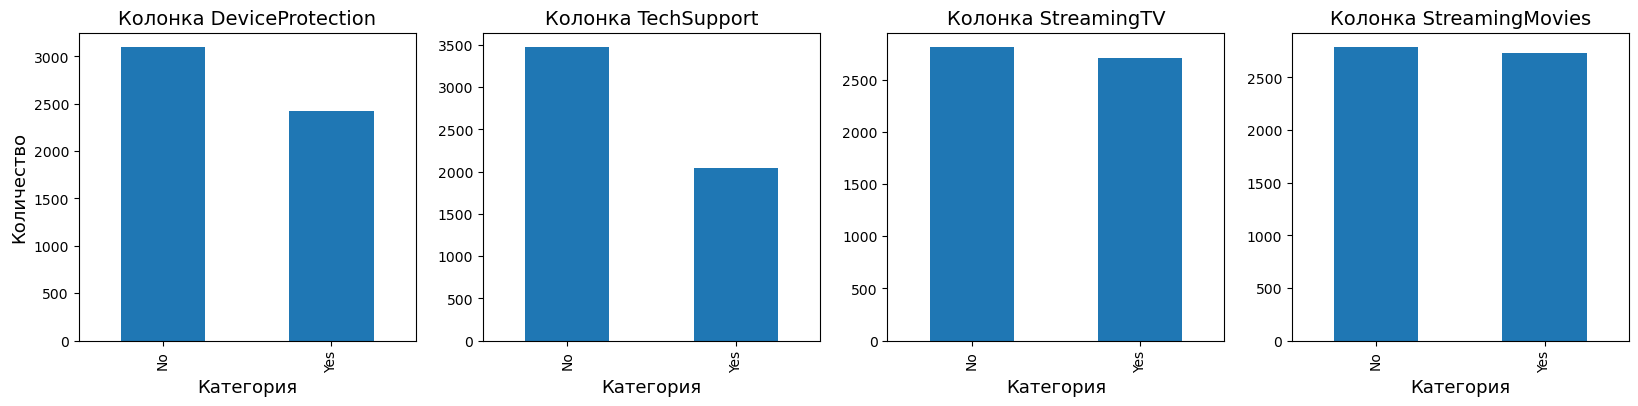

In [11]:
internet_cat_l = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', \
                  'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].set_ylabel('Количество', fontsize=13)
for i in range(3):
    d_internet.groupby(internet_cat_l[i])[internet_cat_l[i]].count().plot(kind='bar', ax = ax[i])
    ax[i].set_title('Колонка ' + internet_cat_l[i], fontsize=14)
    ax[i].set_xlabel('Категория', fontsize=13)

print()
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
ax[0].set_ylabel('Количество', fontsize=13)
for i in range(3, 7):
    d_internet.groupby(internet_cat_l[i])[internet_cat_l[i]].count().plot(kind='bar', ax = ax[i-3])
    ax[i-3].set_title('Колонка ' + internet_cat_l[i], fontsize=14)
    ax[i-3].set_xlabel('Категория', fontsize=13)

Признаки d_phone с данными о подключенных услугах телефонии

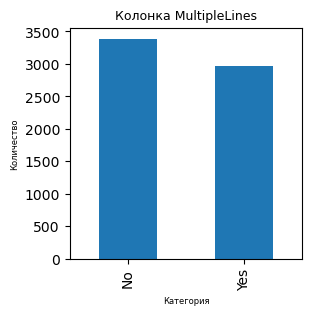

In [12]:
fig, ax = plt.subplots(figsize=(3,3))
d_phone.groupby('MultipleLines')['MultipleLines'].count().plot(kind='bar')
ax.set_title('Колонка MultipleLines', fontsize=9)
ax.set_xlabel('Категория', fontsize=6)
ax.set_ylabel('Количество', fontsize=6);

**Промежуточные выводы:**
* В основных таблицах с пользователями (контракты и перс. данные) **7 043** записей. Это немного, следует использовать k-fold кросс-валидацию при обучении
* В таблице с подключенными интернет услугами **5 517** записей. Значит, интернет от ТелеДом подключен у **78%** пользователей
* В таблице с подключенными услугами телефонии **6 361** записей. Значит, телефон от ТелеДом подключен у **90%** пользователей
* В значениях категориальных переменнх не нашел, 13 из 15 категорий бинарные, одна предполагает одну опцию из трех, еще одна -- из четырех.  

**По распределению:**
* Все необязательные опции менее популярны, чем их отсутствие. Что-то похожее на паритет разве что в опциях StreamingTV и StreamingMovies.
* Самые непопулярные услуги -- антивирус и выделенная линия техподдержки
* Оптика популярнее, чем DSL
* Клиенты предпочитают в основном безбумажное подтерждение оплаты и eCheck в качестве способа оплаты
* Клиенты предпочитают ежемесячный платеж вместо ежгодного или ежедвухлетнего
* По гендеру и семейному положению соотношение примерно поровну
* Пенсионеров земетно меньше, чем трудоспособных Клиентов
* Дети есть чуть меньше, чем у трети Клиентов

**На что обратить внимание при предобработке:**
* Следует обработать типы данных
* Следует привести названия колонок к формату snake_case
* Добавить в таблицу отдельный признак того, что контракт был расторгнут (на основе EndDate)
* После заполнить отсутствующие значения в EndDate первым февралем 2020 года
* Вычислить длительность в днях
* Снести EndDate и BeginDate
* После этого посмотреть распределение по численным признакам

## Шаг 2 Исследовательский анализ и предобработка данных

### 2.1 Приводим столбцы к snake_case

In [13]:
for i in range(4):
    col_new=[]
    for col in l_df[i].columns:
        col_new.append(re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower())

    l_df[i].columns = col_new
    display(list(l_df[i].columns))

['customer_i_d',
 'begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges']

['customer_i_d', 'gender', 'senior_citizen', 'partner', 'dependents']

['customer_i_d',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies']

['customer_i_d', 'multiple_lines']

Готово

### 2.2 Добавление признака расторжения контракта "gone"

**gone == 1**, значит, что Контракт был расторгнут  
**gone == 0**, Контракт активен на 01.02.2020

In [14]:
d_contract['gone'] = ((d_contract['end_date'] != 'No') * 1)

In [15]:
display(d_contract.sort_values('gone'))
print('Доля клиентов, которые расторгли контракт =', '{:.2%}'.format(d_contract['gone'].mean()))

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
4493,8606-OEGQZ,2018-08-01,No,Two year,No,Credit card (automatic),25.30,500.94,0
4491,7853-WNZSY,2020-01-01,No,Month-to-month,Yes,Credit card (automatic),19.75,20.54,0
4490,0442-ZXKVS,2015-08-01,No,One year,Yes,Bank transfer (automatic),115.60,6242.4,0
4489,8259-DZLIZ,2014-10-01,No,One year,Yes,Bank transfer (automatic),53.85,3618.72,0
...,...,...,...,...,...,...,...,...,...
3783,1469-LBJQJ,2014-08-01,2017-09-01,Month-to-month,Yes,Electronic check,105.20,4087.02,1
1068,5536-RTPWK,2015-11-01,2019-04-01,Month-to-month,Yes,Bank transfer (automatic),99.05,4061.05,1
5210,2794-XIMMO,2015-06-01,2018-12-01,One year,Yes,Electronic check,60.45,2716.62,1
3780,1335-MXCSE,2015-07-01,2019-12-01,Two year,Yes,Credit card (automatic),55.25,2928.25,1


Доля клиентов, которые расторгли контракт = 15.63%


Похоже на правду

### 2.3 Обработка begin_date и end_date

У меня было два варианта, чем заполнить end_date там, где d_contract['end_date'] == 'No'  
Если заполнить 31.12.9999 (как обычно заполняются даты ненаступивших событий), то мы допустим утечку целевого признака, поэтому, на мой взгляд, следует заполнить значениями **'2020-02-01'**

In [16]:
# Заполняем отсутствующие значения в end_date датой 2020-02-01
d_contract.loc[d_contract['end_date'] == 'No', 'end_date'] = '2020-02-01'

# Приводим форматы дат
d_contract['begin_date'] = pd.to_datetime(d_contract['begin_date'], format='%Y-%m-%d')
d_contract['end_date'] = pd.to_datetime(d_contract['end_date'], format='%Y-%m-%d')

# Вычисляем duration
d_contract['duration'] = (d_contract['end_date'] - d_contract['begin_date']).dt.days

# Проверяем
display(d_contract.sort_values('duration'))
d_contract.info()

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone,duration
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
...,...,...,...,...,...,...,...,...,...,...
3040,7317-GGVPB,2013-11-01,2020-02-01,Two year,Yes,Credit card (automatic),108.60,8145.0,0,2283
975,2834-JRTUA,2013-11-01,2020-02-01,Two year,Yes,Electronic check,108.05,8184.79,0,2283
4610,2889-FPWRM,2013-10-01,2020-02-01,One year,Yes,Bank transfer (automatic),117.80,9221.38,0,2314
3439,0917-EZOLA,2013-10-01,2020-02-01,Two year,Yes,Bank transfer (automatic),104.15,7915.4,0,2314


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gone               7043 non-null   int32         
 9   duration           7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(5)
memory usage: 522.9+ KB


С одной стороны, все норм, но с другой -- обнаружены пробелы в total_charges там, где должны быть нули, так как нулевой duration.  
Посмотрим, сколько таких значений:

In [17]:
d_contract.loc[d_contract['total_charges'] == ' ', :]

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone,duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0


Немного. Ну и генезис ясен -- Клиенты заключили Контракт в день выгрузки данных, оплат нет.  
Заполним нулями и сразу переведем в float.

In [18]:
d_contract.loc[d_contract['total_charges'] == ' ', 'total_charges'] = 0
d_contract['total_charges'] = d_contract['total_charges'].astype('float')

# Проверяем
d_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gone               7043 non-null   int32         
 9   duration           7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.9+ KB


То, что надо  
Воспользуемся Ограничением 4 "В данных нет зависимости от времени" и снесем begin_date и end_date

In [19]:
d_contract = d_contract.drop(['begin_date', 'end_date'], axis=1)
d_contract.head(3)

,customer_i_d,type,paperless_billing,payment_method,monthly_charges,total_charges,gone,duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123


### 2.4 Анализ распределения численных признаков

Посмотрим на распределение monthly_charges, total_charges и duration.

С учетом значения целевого принака будем работать уже на объединенной таблице.

,monthly_charges,total_charges,duration
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729
std,30.090047,2112.742814,683.130510
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


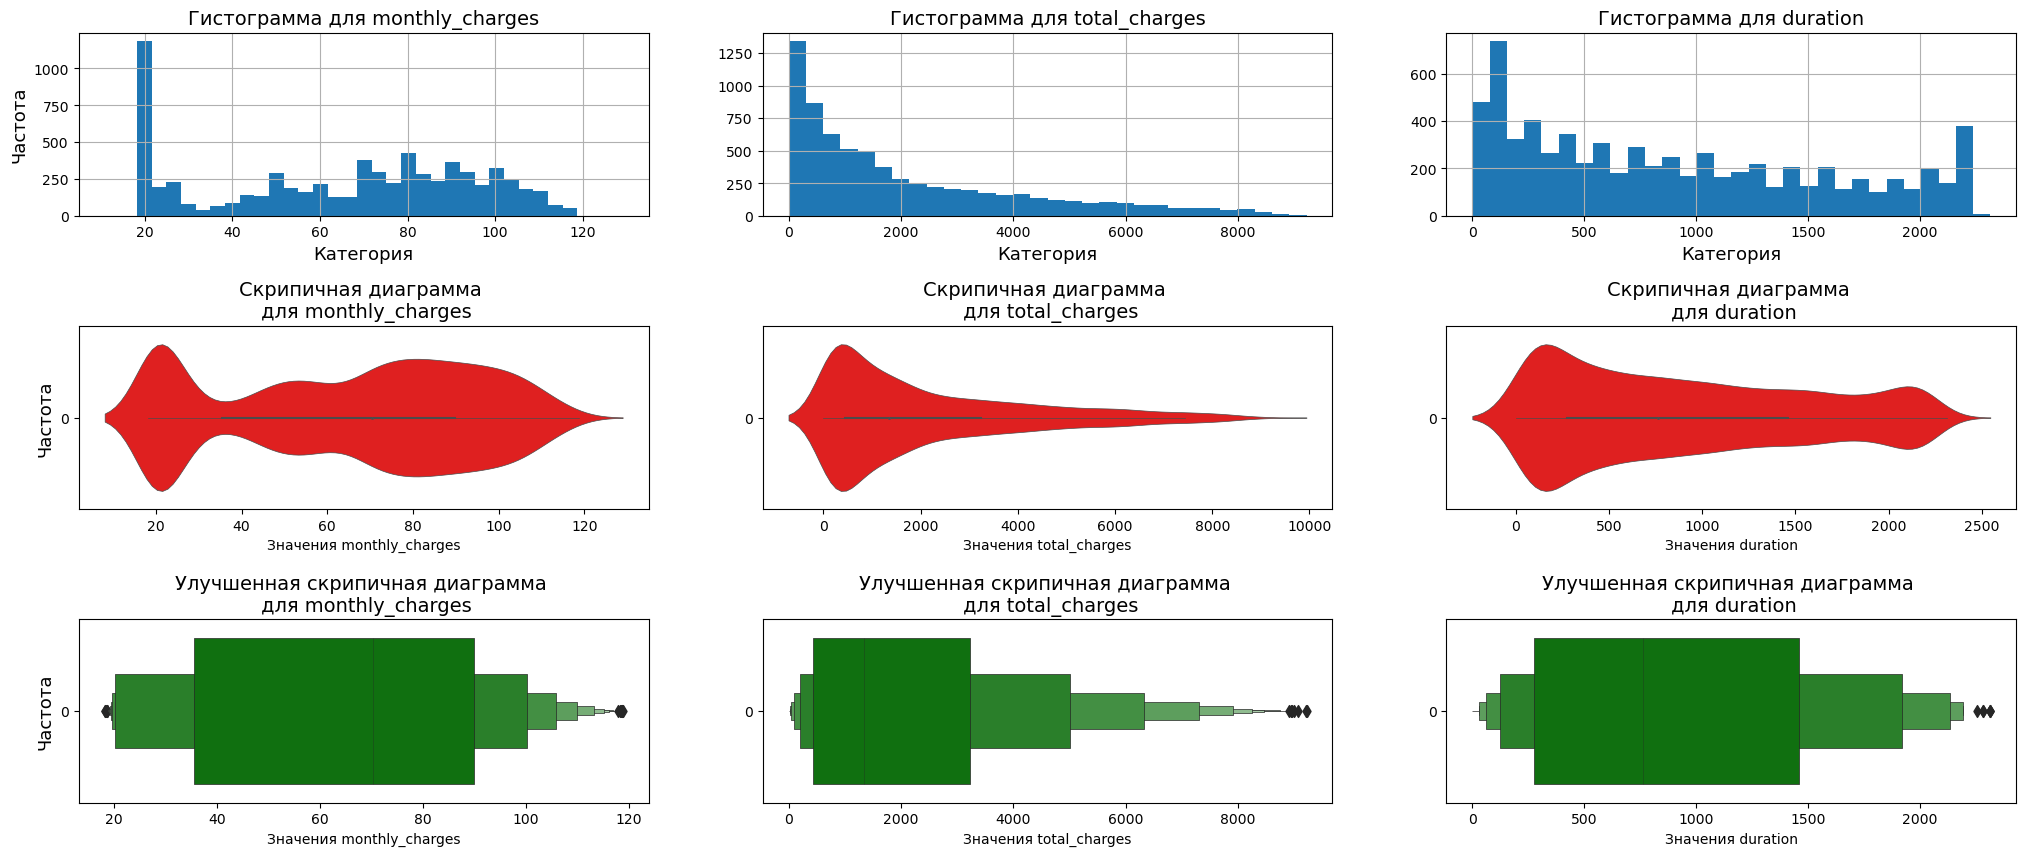

In [20]:
contract_num_l = ['monthly_charges', 'total_charges', 'duration']

# Циферки
display(d_contract[contract_num_l].describe())

# Графики
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(25, 10))
plt.subplots_adjust(hspace=0.6)
ax[0, 0].set_xlim(5, 135)
ax[0, 0].set_ylabel('Частота', fontsize=13)
ax[1, 0].set_ylabel('Частота', fontsize=13)
ax[2, 0].set_ylabel('Частота', fontsize=13)

for i in range(3):
    d_contract[contract_num_l[i]].hist(bins = 30, ax = ax[0, i])
    ax[0, i].set_title('Гистограмма для ' + contract_num_l[i], fontsize=14)
    ax[0, i].set_xlabel('Категория', fontsize=13)
    
    sns.violinplot(data=d_contract[contract_num_l[i]], linewidth=0.5, ax=ax[1, i], orient='h', color='red')
    ax[1, i].set_xlabel('Значения ' + contract_num_l[i])
    ax[1, i].set_title('Cкрипичная диаграмма \n для ' + contract_num_l[i], fontsize=14);
    
    sns.boxenplot(data=d_contract[contract_num_l[i]], linewidth=0.5, ax=ax[2, i], orient='h', color='green')
    ax[2, i].set_xlabel('Значения ' + contract_num_l[i])
    ax[2, i].set_title('Улучшенная скрипичная диаграмма \n для ' + contract_num_l[i], fontsize=14);

Посмотрим внимательнее на пик около двадцати долларов в monthly_charges

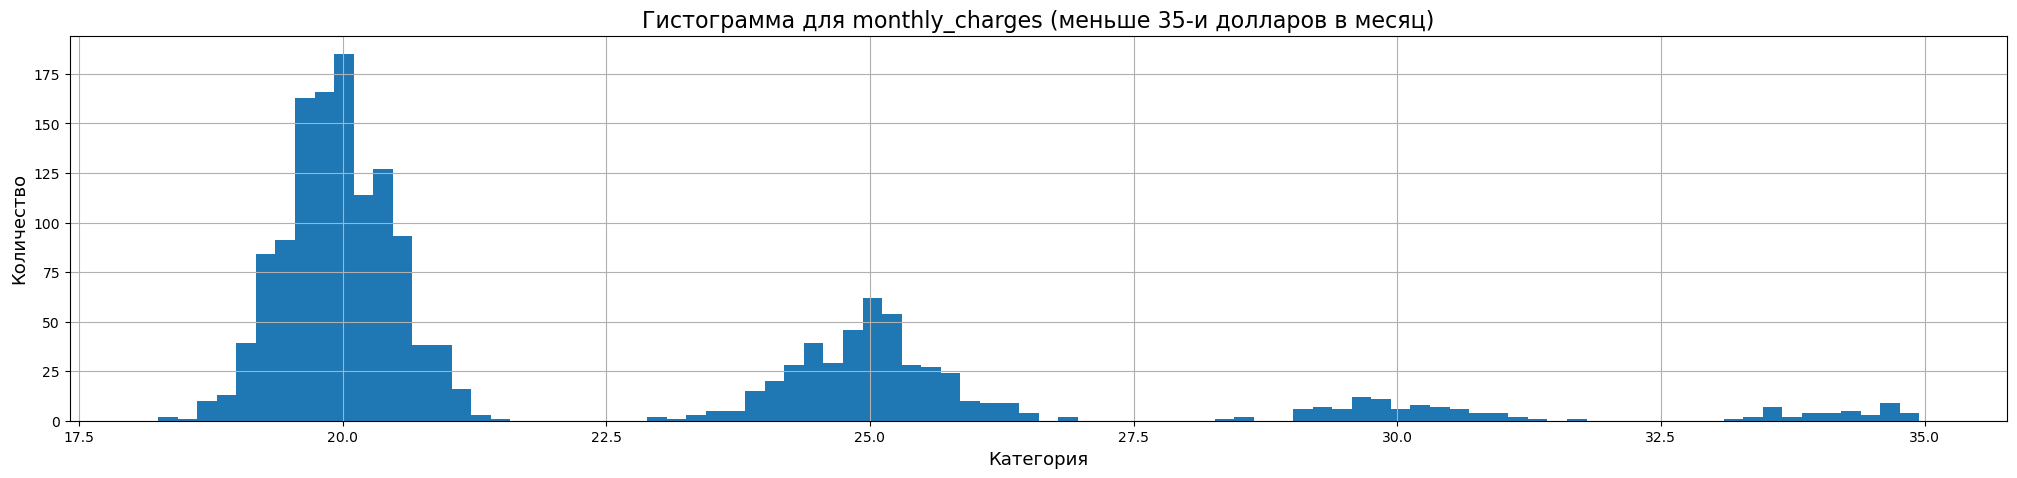

In [21]:
ax = d_contract.loc[d_contract['monthly_charges'] < 35, 'monthly_charges'].hist(bins = 90, figsize=(25, 5))
ax.set_title('Гистограмма для monthly_charges (меньше 35-и долларов в месяц)', fontsize=16)
ax.set_xlabel('Категория', fontsize=13)
ax.set_ylabel('Количество', fontsize=13);

**Промежуточные выводы:**

1. Получили целевой признак "gone". Он несбалансирован -- контракт расторгли 15.63% Клиентов
2. Добавили признак "duration" -- количество календарных дней между стартом контракта и его разрывом (между стартом контракта и 01.02.2020, если контракт на момент выгрузки активен)
3. Численные признаки:
    * **monthly_charges** имеет пик в самом начале, до 30 долларов. Забегая вперед, это пользователи, у которых подключет только телефон или только DSL интернет. Дальше плавный рост до 80 долларови спад до 120 долларов. Выбросов сравнительно немного. Большая часть Клиентов платит от 35-и до 90 долларов в месяц. Горбы с шагом в пять долларов можно объяснить тем, что у таких клиентов обычно по одной услуге, поэтому на ежемесячную стоимость сильно влияет фиксированной значение тарифа.
    * **total_charges и duration**, очевидно, взаимозависимы, однако, для duration есть пик после 2 200 дней, однако эти долгожители так же явно на общих выплатах не отражаются. Судя по всему, этот пик размазан наличием пользователей с небольшим monthly_charges. В остальном динамика схожа, пик на старте (до 500 долларов и 200 дней соответственно), потом плавный спад. Отмечу, что спад у duration не такой драматичный, если сравнивать с total_charges. Клиенты более равномерно распределены по продолжительности, чем по суммарным платежам. Отмечу также "гребенку" в duration. Судя по всему, тут виной то, что данные по датам округлены месяцем.    

## Шаг 3. Объединение данных

1. Объединим по customer_i_d в общую таблицу
2. Снесем customer_i_d за ненадобностью
3. Заполним пропуски значениями, которые бы явно говорили об отсутствии ШПД и телефонии для значений из таблиц d_internet и d_phone соответственно

In [22]:
d_total = d_contract.join(d_personal.set_index('customer_i_d'), how='inner', on='customer_i_d').\
join(d_internet.set_index('customer_i_d'), on='customer_i_d').\
join(d_phone.set_index('customer_i_d'), on='customer_i_d')
d_total

,customer_i_d,type,paperless_billing,payment_method,monthly_charges,total_charges,gone,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,2035.20,0,730,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7430.40,0,2191,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,325.60,0,337,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,520.80,0,215,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


Похоже на правду  
Вытащим целевой признак в конец датафрейма.

In [23]:
d_total = d_total[['customer_i_d', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'duration', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines', 'gone']]

In [24]:
d_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   duration           7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_t_v      5517 non-n

Есть пропуски  
Заполним отсутствующие значения по отсутствующим основным услугам
- **no_phone** -- не подключен стационарный телефон от «ТелеДом»
- **no_internet** -- отсутствует подключение к интернету от «ТелеДом»

In [25]:
d_total['multiple_lines'] = d_total['multiple_lines'].fillna('no_phone')
d_total = d_total.fillna('no_internet')
d_total.head(12)

,customer_i_d,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,gone
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone,0
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,1150.96,337,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,671,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
7,6713-OKOMC,Month-to-month,No,Mailed check,29.75,300.48,306,Female,0,No,No,DSL,Yes,No,No,No,No,No,no_phone,0
8,7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3573.68,945,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,6388-TABGU,One year,No,Bank transfer (automatic),56.15,1628.35,882,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,1


In [26]:
d_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   duration           7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_t_v      7043 non-n

Заполнили  
Проверим, есть ли Клиенты вообще без услуг:

In [27]:
d_total.loc[(d_total['internet_service'] == 'no_internet') & (d_total['multiple_lines'] == 'no_phone'), :].shape

(0, 20)

Таких нет

## Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Посмотрим на поведение числовых переменных при различных значениях целевого признака  
Так как у нас класс не особо сбалансирован, отображать предлагаю нормализованный вариант

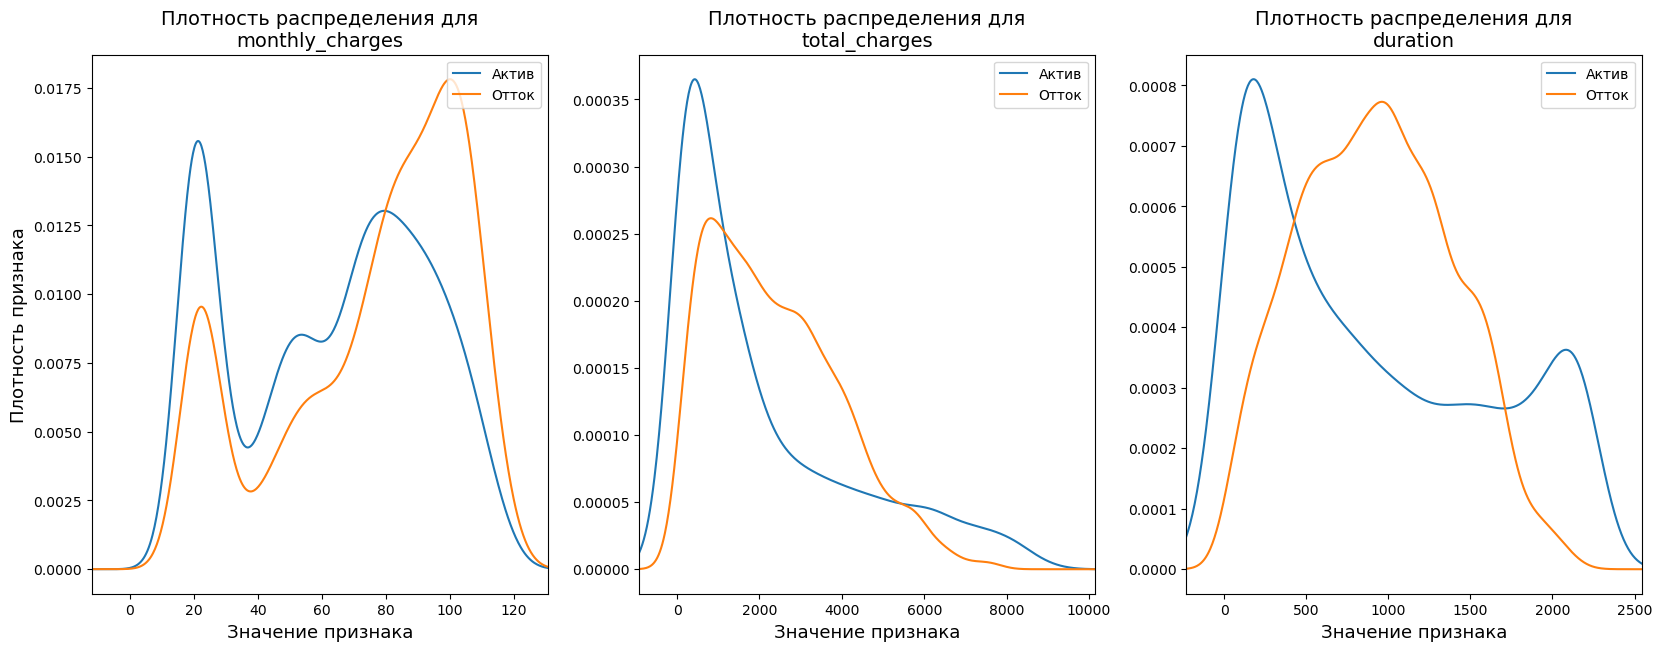

In [28]:
total_num_l = ['monthly_charges', 'total_charges', 'duration']
total_target_l = ['gone']
total_cat_l = list(set(d_total.columns) - set(total_num_l) - set(total_target_l) - set(['customer_i_d']))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

for i in range(3):
    d_total.loc[d_total['gone'] == 0, total_num_l[i]].\
    plot.kde(bw_method=0.2, ax=ax[i], xlim=[max(d_total[total_num_l[i]]) * -0.1, max(d_total[total_num_l[i]]) * 1.1])
    
    d_total.loc[d_total['gone'] == 1, total_num_l[i]].\
    plot.kde(bw_method=0.2, ax=ax[i], xlim=[max(d_total[total_num_l[i]]) * -0.1, max(d_total[total_num_l[i]]) * 1.1])
    
    ax[i].set_title('Плотность распределения для\n' + total_num_l[i], fontsize=14)
    ax[i].set_xlabel('Значение признака', fontsize=13)
    if i == 0:
        ax[i].set_ylabel('Плотность признака', fontsize=13)
    else:
        ax[i].set_ylabel('', fontsize=13)
    ax[i].legend(['Актив', 'Отток'], loc='upper right')

Что видно на графиках:

- **monthly_charges** распределены принципиально иначе в зависимости от значения таргета. Судя по всему, Клиенты перед уходом платят больше. Этот признак, думаю, будет важен для обучения.
- Кажется, что **total_charges** распределен похожим образом, но снижение плотности после тысячи долларов у ушедших более плавное
- В **duration** -- самое интересное, на мой взгляд. Пик на сравнительно небольшой продолжительности -- около года, у активных. Судя по всему, "ТелеДом" год-полтора назад начал активно расширяться. Ушедшие былы Клиентами "ТелеДом"-а от полутора до четырех-пяти лет, в основном. Совсем уж долгожители не уходят. Тоже крайне важный признак.

Так или иначе, на мультиколлинеарности будет понятнее.

Теперь взглянем на категориальные признаки.

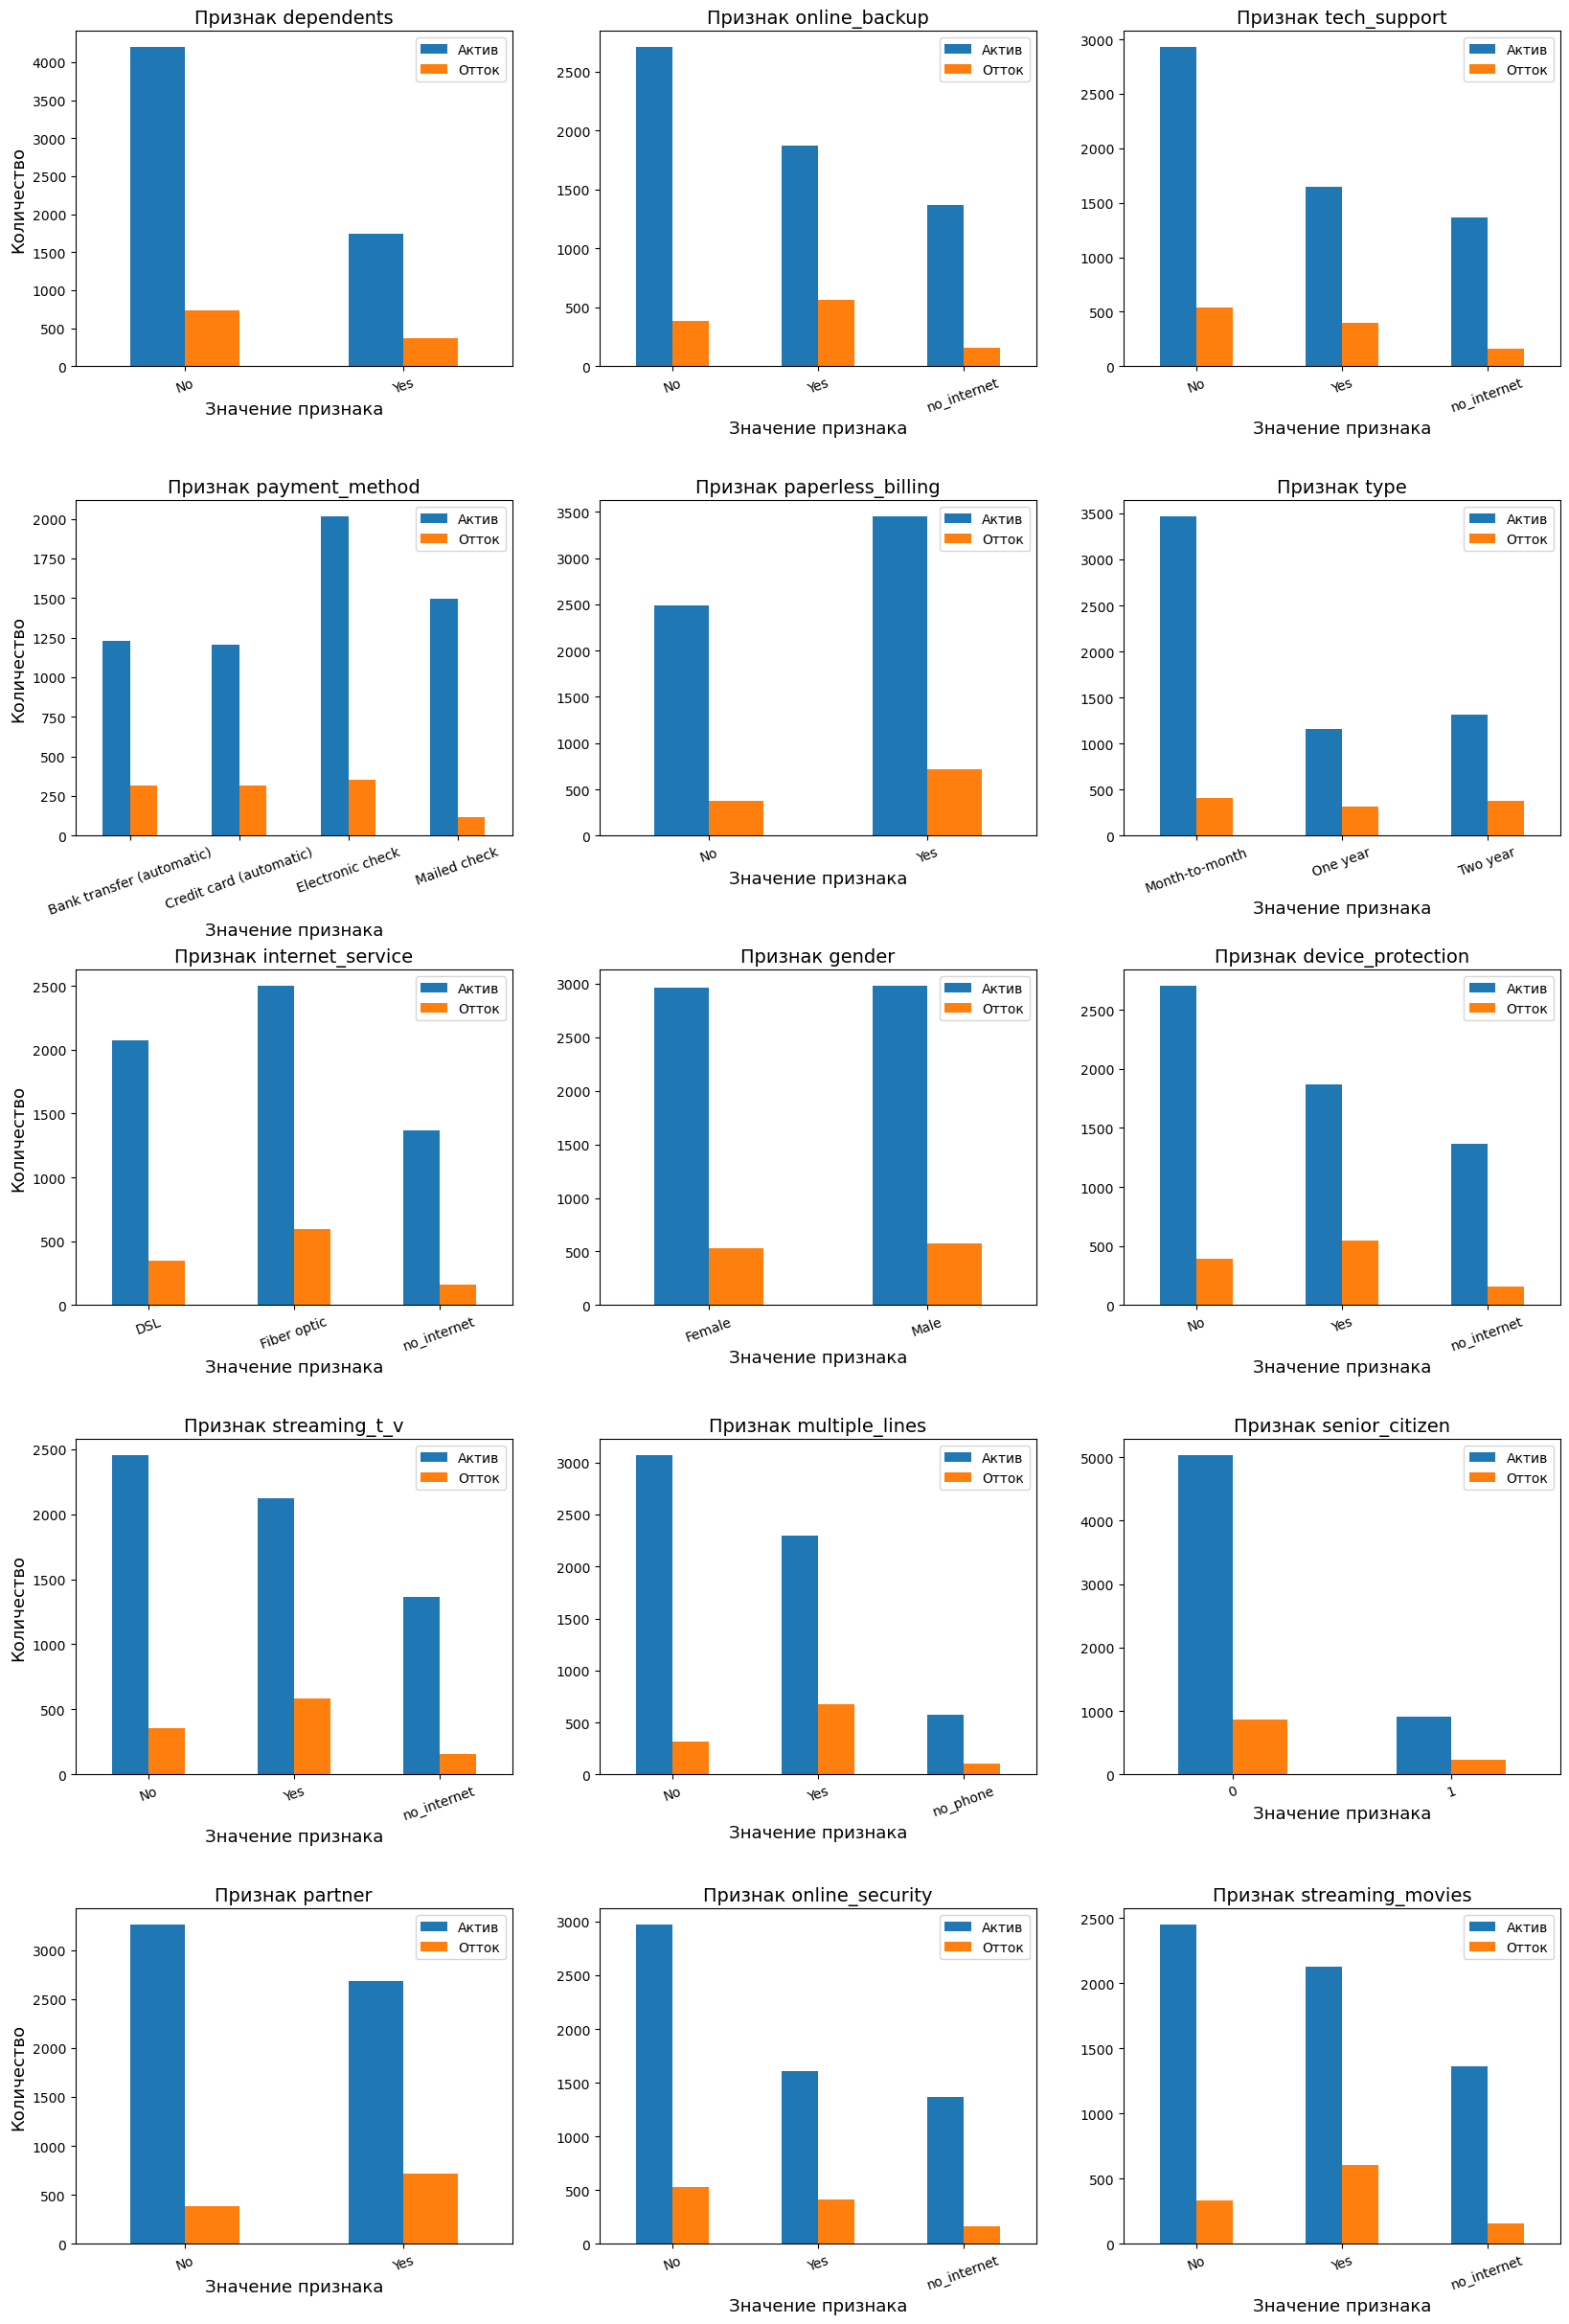

In [29]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20, 30))
plt.subplots_adjust(hspace=0.4)
for i in range(15):
    
    d_total.pivot_table(index=total_cat_l[i], aggfunc='count', columns='gone', values='customer_i_d').\
    plot(kind='bar',  ax = ax[i // 3, i % 3])
    
    ax[i // 3, i % 3].set_title('Признак ' + total_cat_l[i], fontsize=14)
    ax[i // 3, i % 3].set_xlabel('Значение признака', fontsize=13)
    ax[i // 3, i % 3].legend(['Актив', 'Отток'], loc='upper right')
    if i % 3 == 0:
        ax[i // 3, i % 3].set_ylabel('Количество', fontsize=13)
    else:
        ax[i // 3, i % 3].set_ylabel('', fontsize=13)
    ax[i // 3, i % 3].tick_params(axis='x', labelrotation = 20)

Меня тут больше всего интересуют те признаки, у которых распределение заметно отличается в зависимости от таргета.

Например, **gender** явно не нужен -- он одинаково распределен и по значениям признака, и по значаниям таргета.

Итого, интересные признаки:
- **device_protection**, у ушедших лидирует наличие антивируса, у активных -- его отсутствие
- **type**, у активных лидирует ежемесячная оплата, у ушедших более-меннее поровну
- **online_backup**, ситуация аналогична device_protection
- **partner**, в уходящих больше Клиентов в браке, среди активных больше холостых
- **streaming_movies**, ситуация аналогична device_protection
- **payment_method**, ушедшие очень не любят оплату по почте, остальные варианты -- поровну. Активные же наоборот, по почте отношения приветствуют, но самый популярный метод -- через eCheck.
- **multiple_lines**, ситуация аналогична device_protection
- **streaming_t_v**, ситуация аналогична device_protection

Предчуствую, что на мультиколлинеарности будет куча взаимозависимых признаков. 

### 4.1 Проверка признаков на мультиколлинеарность

In [30]:
def corr_plot(df):
    # вычисление коэффициентов корреляции phi для датафрейма df
    phik_overview = df.phik_matrix(interval_cols=total_num_l)

    display(phik_overview)
    print(2 * '\n')
    # визуализация тепловой карты коэффициентов корреляции
    plot_correlation_matrix(phik_overview.values, \
                            x_labels=phik_overview.columns, \
                            y_labels=phik_overview.index, \
                            title=r"correlation $\phi_K$", \
                            fontsize_factor=1.5, \
                            figsize=(15, 12));

,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,gone
type,1.000000,0.106860,0.277462,0.388266,0.470860,0.634155,0.000000,0.086231,0.179736,0.147680,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410,0.094015
paperless_billing,0.106860,1.000000,0.370495,0.467783,0.201703,0.026799,0.000000,0.242133,0.013218,0.172593,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953,0.083398
payment_method,0.277462,0.370495,1.000000,0.399536,0.335666,0.350964,0.000000,0.292725,0.243008,0.224903,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849,0.214832
monthly_charges,0.388266,0.467783,0.399536,1.000000,0.711035,0.387579,0.009025,0.304691,0.203237,0.184213,0.918980,0.812633,0.818858,0.827318,0.816603,0.864642,0.863641,0.710101,0.225925
total_charges,0.470860,0.201703,0.335666,0.711035,1.000000,0.848337,0.000000,0.135650,0.381958,0.084247,0.490081,0.516538,0.550544,0.558393,0.527838,0.555322,0.554030,0.467787,0.302890
duration,0.634155,0.026799,0.350964,0.387579,0.848337,1.000000,0.000000,0.063315,0.453688,0.198729,0.060845,0.346398,0.366170,0.374702,0.353438,0.306675,0.307297,0.347289,0.374569
gender,0.000000,0.000000,0.000000,0.009025,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581
senior_citizen,0.086231,0.242133,0.292725,0.304691,0.135650,0.063315,0.000000,1.000000,0.016992,0.324576,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925,0.086159
partner,0.179736,0.013218,0.243008,0.203237,0.381958,0.453688,0.000000,0.016992,1.000000,0.652122,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.086249,0.226688
dependents,0.147680,0.172593,0.224903,0.184213,0.084247,0.198729,0.000000,0.324576,0.652122,1.000000,0.108463,0.117219,0.097766,0.094597,0.109753,0.088193,0.084684,0.011198,0.046871


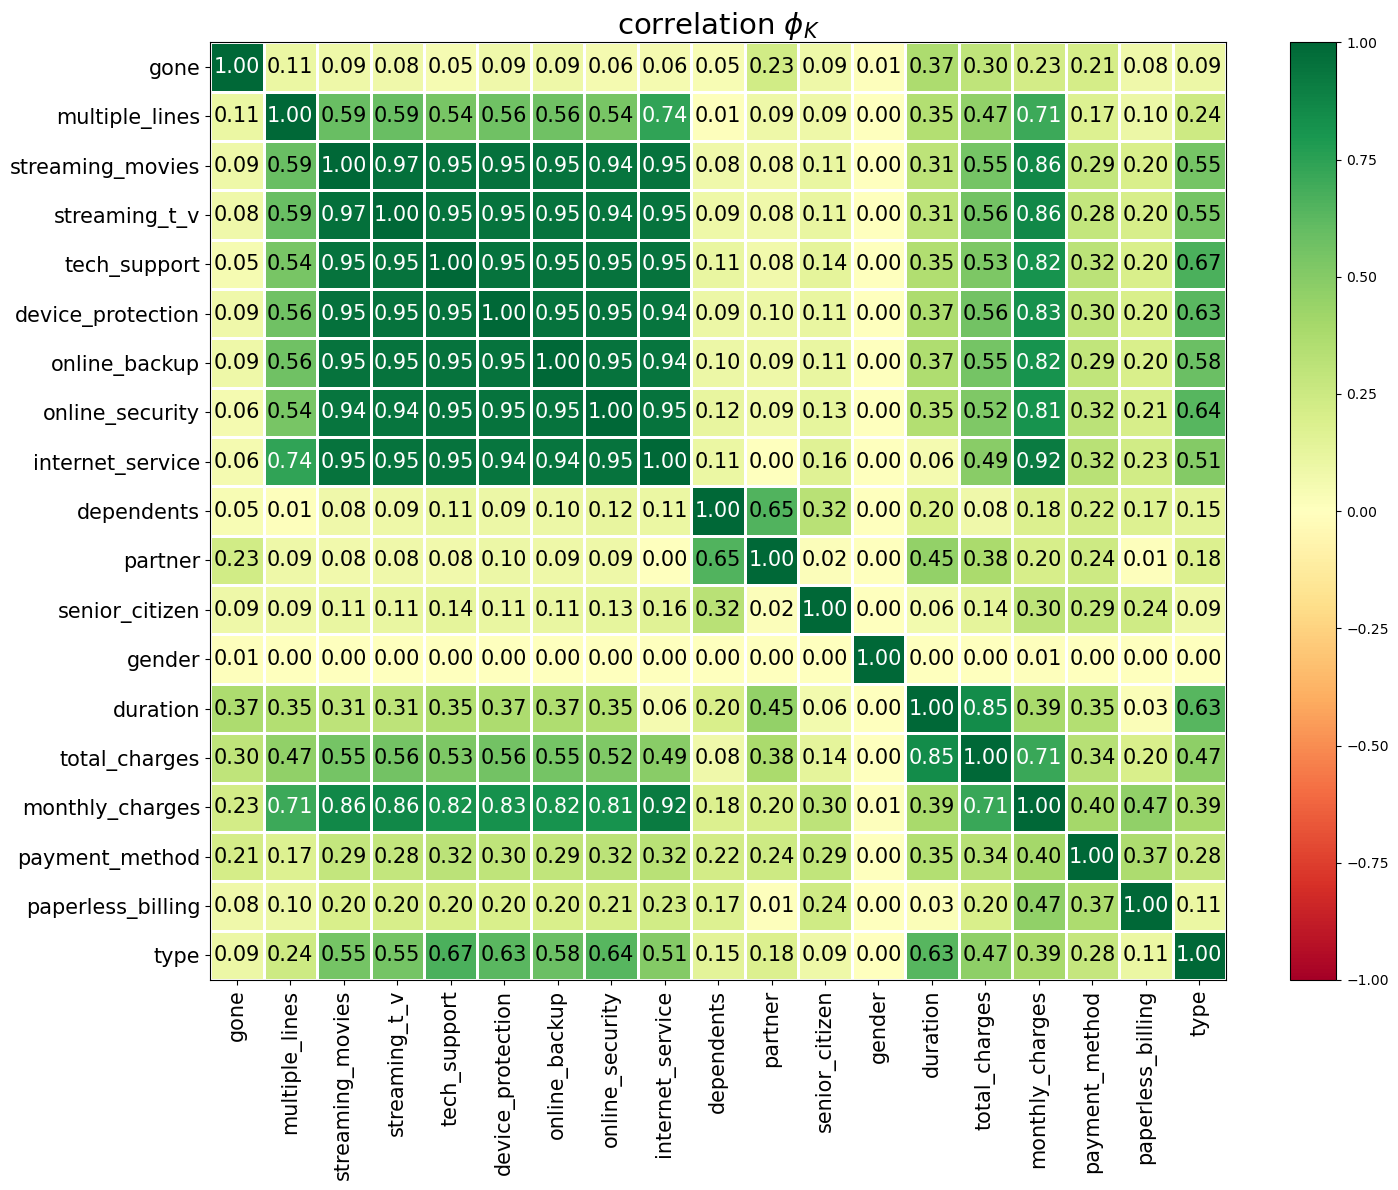

In [31]:
corr_plot(d_total.drop('customer_i_d', axis=1))

Убираем признаки 
- с высоким значением с другими признаками, иными словами, разбиваем взаимозависимые группы:  
streaming_t_v, tech_support, device_protection, online_backup, online_security, internet_service, total_charges
- с низким значением с таргетом:  
gender

In [32]:
total_l = ['type', 'paperless_billing', 'payment_method', \
           'monthly_charges', 'duration', \
           'senior_citizen', 'partner', 'dependents', \
           'streaming_movies', 'multiple_lines', \
           'gone']

Проверяем:

,type,paperless_billing,payment_method,monthly_charges,duration,senior_citizen,partner,dependents,streaming_movies,multiple_lines,gone
type,1.000000,0.106860,0.277462,0.388266,0.634155,0.086231,0.179736,0.147680,0.553556,0.244410,0.094015
paperless_billing,0.106860,1.000000,0.370495,0.467783,0.026799,0.242133,0.013218,0.172593,0.202241,0.099953,0.083398
payment_method,0.277462,0.370495,1.000000,0.399536,0.350964,0.292725,0.243008,0.224903,0.285525,0.174849,0.214832
monthly_charges,0.388266,0.467783,0.399536,1.000000,0.387579,0.304691,0.203237,0.184213,0.863641,0.710101,0.225925
duration,0.634155,0.026799,0.350964,0.387579,1.000000,0.063315,0.453688,0.198729,0.307297,0.347289,0.374569
senior_citizen,0.086231,0.242133,0.292725,0.304691,0.063315,1.000000,0.016992,0.324576,0.113778,0.087925,0.086159
partner,0.179736,0.013218,0.243008,0.203237,0.453688,0.016992,1.000000,0.652122,0.077506,0.086249,0.226688
dependents,0.147680,0.172593,0.224903,0.184213,0.198729,0.324576,0.652122,1.000000,0.084684,0.011198,0.046871
streaming_movies,0.553556,0.202241,0.285525,0.863641,0.307297,0.113778,0.077506,0.084684,1.000000,0.586815,0.086577
multiple_lines,0.244410,0.099953,0.174849,0.710101,0.347289,0.087925,0.086249,0.011198,0.586815,1.000000,0.105101


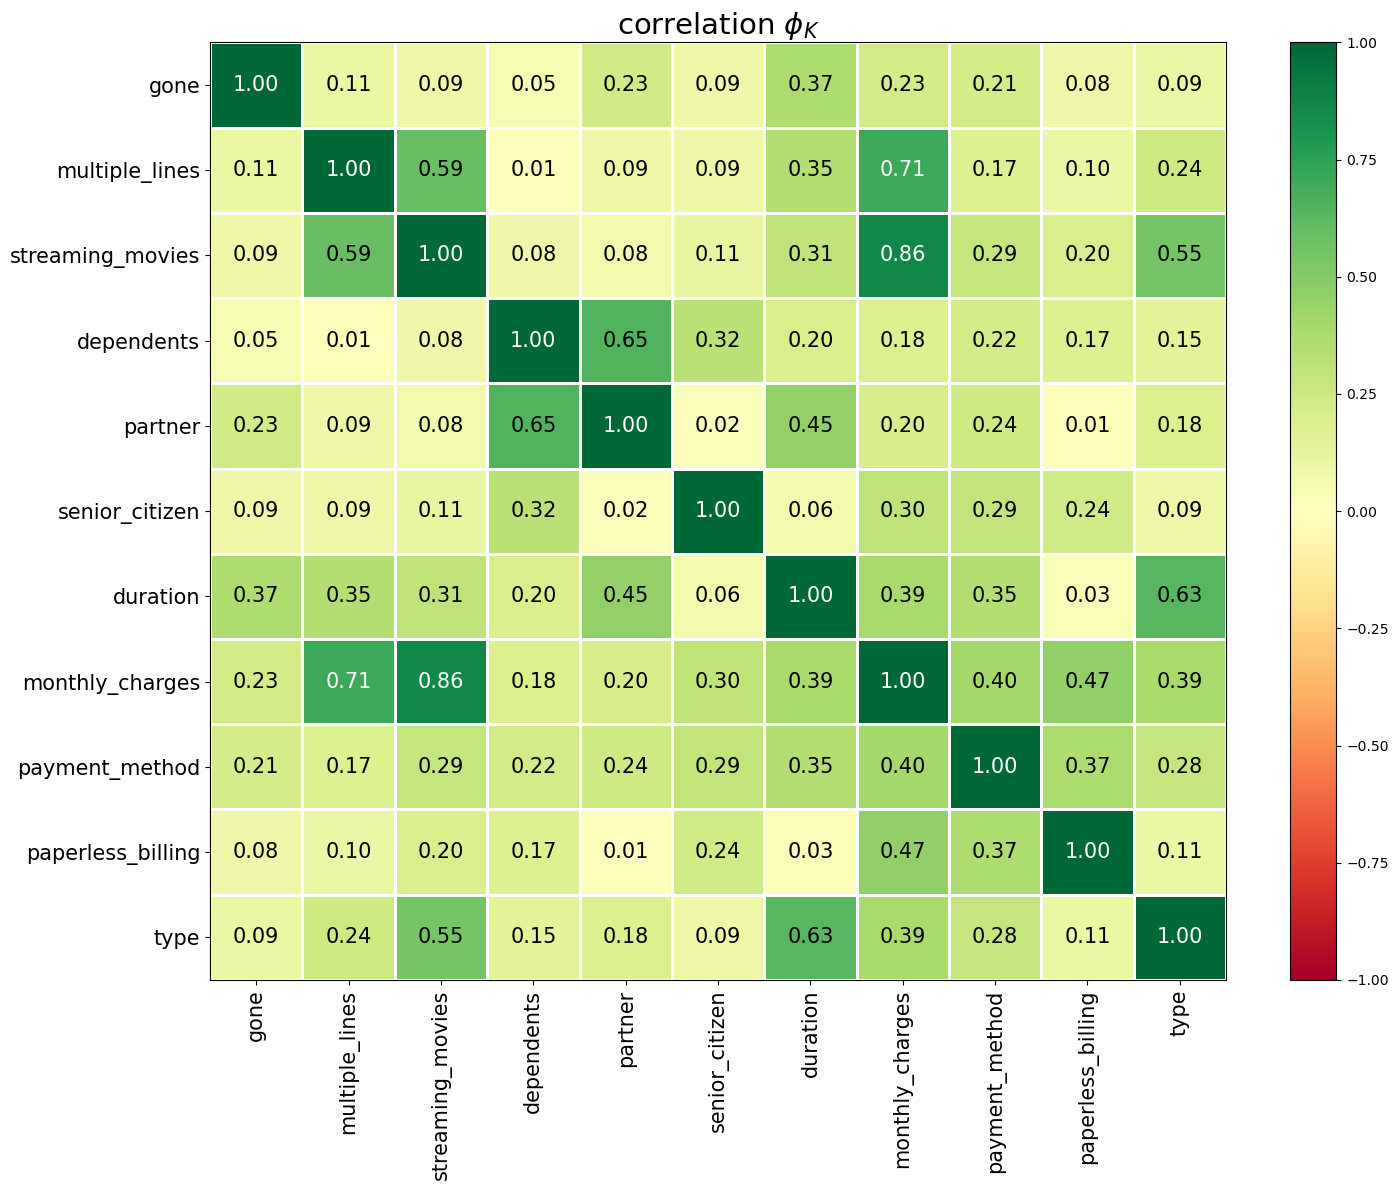

In [33]:
corr_plot(d_total[total_l])

Стало намного лучше  

Отдельно сомнения по streaming_movies. Его бы тоже снести, но это последний признак про интренет услуги. Без них как-то странно обучать модель. Посмотрим, как покажет себя она на тестовой выборке. Если всё будет не очень хорошо, то снесу и пересчитаю.

В качестве промежуточного вывода можно крупными мазками обрисовать портрет уходящего Клиента:

1. Клиент уже некоторое время пользуется услегами Компании "ТелеДом", от полутора лет до четырех-пяти
2. У него подключено некоторое количество дополнительных услуг (или по телефонии, или по ШПД)
3. Ежемесячный платеж вероятно от шестидесяти долларов
4. Он не отдает особого предпочтения ежемесячному варианту оплаты
5. Очень не любит оплачивать услуги по почте
6. Если Клиент в браке, то вероятность ухода несколько повышается

## Шаг 5. Подготовка данных

### 5.1 Разделение данных

Выделим целевой признак и разделим наши выборки:

In [34]:
d_final = d_total[total_l].copy()
cat_features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'streaming_movies', \
                'multiple_lines']

In [35]:
d_final_features = d_final.drop('gone', axis=1)
d_final_target = d_final['gone']

In [36]:
d_final_features[cat_features] = d_final_features[cat_features].astype('category')

In [37]:
def features_split(f, t):
        
    f_train, f_test, t_train, t_test = train_test_split(f, t, test_size=0.25, stratify=t, random_state=RAND_FIX)
    tribe = [f_train, t_train, f_test, t_test]
        
    for i in range(len(tribe)):
        tribe[i] = tribe[i].reset_index(drop=True)
        print(tribe[i].shape)
    
    print()
    
#     Проверяем, не потерялось ли после разделение какое-либо значение категории
    for col in cat_features:
        print('Количество уникальных данных в колонке', col)
        for i in range(0, len(tribe), 2):
            print(len(tribe[i][col].unique()), end = ' ')
        print()
    
    print()
    
    print('Доля ушедших в обучающей выборке', t_train.mean())
    print('Доля ушедших в тестовой выборке', t_test.mean())
    
    return tribe[0], tribe[1], tribe[2], tribe[3]

In [38]:
features_train, target_train, features_test, target_test = features_split(d_final_features, d_final_target)

(5282, 10)
(5282,)
(1761, 10)
(1761,)

Количество уникальных данных в колонке type
3 3 
Количество уникальных данных в колонке paperless_billing
2 2 
Количество уникальных данных в колонке payment_method
4 4 
Количество уникальных данных в колонке senior_citizen
2 2 
Количество уникальных данных в колонке partner
2 2 
Количество уникальных данных в колонке dependents
2 2 
Количество уникальных данных в колонке streaming_movies
3 3 
Количество уникальных данных в колонке multiple_lines
3 3 

Доля ушедших в обучающей выборке 0.1563801590306702
Доля ушедших в тестовой выборке 0.15616127200454288


Разделилось приемлемо -- никакие категориальные признаки не потерялись, мощности такие, как и предполагалось

### 5.2 Подготовка трансформаторов и пайплайнов

Обучать будем четыре модели, каждая из которых требует свой подход к обработке категориальных переменных:  

| Модель | One-Hot Encoding | Ordinal Encoding  | Category Data Type |
| :--- | :---: | :---: | :---: |
| **LogisticRegression** | ✔ |  |  |
| **DecisionTreeClassifier** |  | ✔ |  |
| **CatBoostClassifier** |  |  | ✔ |
| **LGBMClassifier** |  |  | ✔ |



Под каждый случай готовим трансформеры:

In [39]:
ct_ohe = ColumnTransformer([('ohe', OneHotEncoder(drop='first'), selector(dtype_include="category")),\
                            ('scal', StandardScaler(), selector(dtype_exclude="category"))], \
                           verbose_feature_names_out=False)

ct_ord = ColumnTransformer([('ord', OrdinalEncoder(), selector(dtype_include="category")),\
                            ('scal', StandardScaler(), selector(dtype_exclude="category"))], \
                           verbose_feature_names_out=False)

ct_cat = ColumnTransformer([('ohe', 'passthrough', selector(dtype_include="category")),\
                            ('scal', StandardScaler(), selector(dtype_exclude="category"))], \
                           verbose_feature_names_out=False).set_output(transform="pandas")

Определяем модели:

In [40]:
model_l = LogisticRegression(random_state=RAND_FIX)
model_t = DecisionTreeClassifier(random_state=RAND_FIX)
model_cat = CatBoostClassifier(random_state=RAND_FIX, cat_features = cat_features, logging_level='Silent')
model_lgbm = LGBMClassifier(random_state=RAND_FIX, verbosity=0)

Определяем пайплайны

In [41]:
pipe_l = Pipeline([('transform', ct_ohe), ('classifier', model_l)])
pipe_t = Pipeline([('transform', ct_ord), ('classifier', model_t)])
pipe_cat = Pipeline([('transform', ct_cat), ('classifier', model_cat)])
pipe_lgbm = Pipeline([('transform', ct_cat), ('classifier', model_lgbm)])

Готовим костыль для проверки работы Ревьюером:

In [42]:
if MODE == 'check':
    
    tree_depth_min, tree_depth_max = 10, 11
    tree_iter = 1
    
    cat_iter_min, cat_iter_max = 700, 701
    cat_depth_min, cat_depth_max = 5, 6
    cat_l_rate_min, cat_l_rate_max = 0.121, 0.123
    cat_iter = 1
        
    lgb_iter_min, lgb_iter_max = 350, 351
    lgb_depth_min, lgb_depth_max = 110, 111
    lgb_leaves_min, lgb_leaves_max = 20, 21
    lgb_l_rate_min, lgb_l_rate_max = 0.401, 0.402
    lgb_iter = 1
    
    n_jobs = None
    verb = 0
    
else:
    
    tree_depth_min, tree_depth_max = 1, 100
    tree_iter = 10
    
    cat_iter_min, cat_iter_max = 500, 1501
    cat_depth_min, cat_depth_max = 4, 30
    cat_l_rate_min, cat_l_rate_max = 0.001, 0.5
    cat_iter = 50
    
    lgb_iter_min, lgb_iter_max = 50, 1051
    lgb_depth_min, lgb_depth_max = 5, 121
    lgb_leaves_min, lgb_leaves_max = 20, 321
    lgb_l_rate_min, lgb_l_rate_max = 0.001, 0.5
    lgb_iter = 100
    
    n_jobs = -1
    verb = 10

Фиксируем параметры моделей:

In [43]:
param_for_l = {}

param_for_t = {'classifier__max_depth' : range(tree_depth_min, tree_depth_max)}

param_for_cat = {'classifier__learning_rate' : np.arange(cat_l_rate_min, cat_l_rate_max, 0.02), \
                 'classifier__iterations' : range(cat_iter_min, cat_iter_max, 100), \
                 'classifier__depth' : range(cat_depth_min, cat_depth_max)}

param_for_gbm = {'classifier__num_iterations' : range(lgb_iter_min, lgb_iter_max, 100), \
                 'classifier__max_depth' : range(lgb_depth_min, lgb_depth_max, 5), \
                 'classifier__num_leaves' : range(lgb_leaves_min, lgb_leaves_max, 5), \
                 'classifier__learning_rate': np.arange(lgb_l_rate_min, lgb_l_rate_max, 0.02)}

Готовим рандомизаторы для поиска гиперпараметров и кросс-валидации:

In [44]:
grid_model_l = RandomizedSearchCV(estimator=pipe_l, param_distributions = param_for_l, \
                                    n_iter=1, cv=4, scoring='roc_auc', random_state=RAND_FIX, verbose=verb)

grid_model_t = RandomizedSearchCV(estimator=pipe_t, param_distributions = param_for_t, \
                                    n_iter=tree_iter, cv=4, scoring='roc_auc', random_state=RAND_FIX, verbose=verb)

grid_model_cat = RandomizedSearchCV(estimator=pipe_cat, param_distributions = param_for_cat, \
                                    n_iter=cat_iter, cv=4,  n_jobs=n_jobs, scoring='roc_auc', \
                                    random_state=RAND_FIX, verbose=verb)

grid_model_gbm = RandomizedSearchCV(estimator=pipe_lgbm, param_distributions = param_for_gbm, \
                                    n_iter=lgb_iter, cv=4, n_jobs=n_jobs, scoring='roc_auc', \
                                    random_state=RAND_FIX, verbose=verb)

## Шаг 6 Обучение моделей машинного обучения

Запускаем обучение:

In [45]:
grid_model_l.fit(features_train, target_train)
grid_model_t.fit(features_train, target_train)
grid_model_cat.fit(features_train, target_train)
grid_model_gbm.fit(features_train, target_train);

Выводим результаты:

In [46]:
d_res = {'depth/max_depth':['', grid_model_t.best_params_['classifier__max_depth'], \
                            grid_model_cat.best_params_['classifier__depth'], \
                            grid_model_gbm.best_params_['classifier__max_depth']],\
         'iterations':['', '', \
                       grid_model_cat.best_params_['classifier__iterations'], \
                       grid_model_gbm.best_params_['classifier__num_iterations']],\
         'learning_rate':['', '', grid_model_cat.best_params_['classifier__learning_rate'], \
                          grid_model_gbm.best_params_['classifier__learning_rate']], \
         'fit_time':[grid_model_l.refit_time_, grid_model_t.refit_time_, \
                     grid_model_cat.refit_time_, grid_model_gbm.refit_time_],\
         'ROC_AUC score':[grid_model_l.best_score_, grid_model_t.best_score_, \
                       grid_model_cat.best_score_, grid_model_gbm.best_score_]}
df_res = pd.DataFrame(index=['LogisticRegression', 'DecisionTree', 'CatBoost', 'LightGBM'], data=d_res) 

display(df_res.sort_values(by='ROC_AUC score', ascending=False))

,depth/max_depth,iterations,learning_rate,fit_time,ROC_AUC score
CatBoost,5,700,0.121,16.362198,0.912439
LightGBM,110,350,0.401,0.131845,0.882308
LogisticRegression,,,,0.023539,0.755916
DecisionTree,10,,,0.024214,0.735314


В лидерах CatBoost и LightGBM с
* CatBoost ROC_AUC = 0.91
* LightGBM ROC_AUC = 0.88

## Шаг 7. Выбор лучшей модели

Обучается LightGBM на два порядка быстрее, чем CatBoost, но воспользуемся Ограничением 5 "Заказчик не выставил нефункциональных требований. Ограничения на время обучения и предсказания модели отсутствуют." и сделаем однозначный выбор в пользу 

**CatBoostClassifier**
* learning_rate == 0.121,
* iterations == 700,
* depth == 5

Запустим тестирование обученной модели

In [47]:
pred_proba = grid_model_cat.predict_proba(features_test)
print('ROC_AUC на тестовой выборке равен', roc_auc_score(target_test, pred_proba[:, 1]))

ROC_AUC на тестовой выборке равен 0.9317215220849138


Значение целевого показателя достигнуто  

Визуализируем результаты:

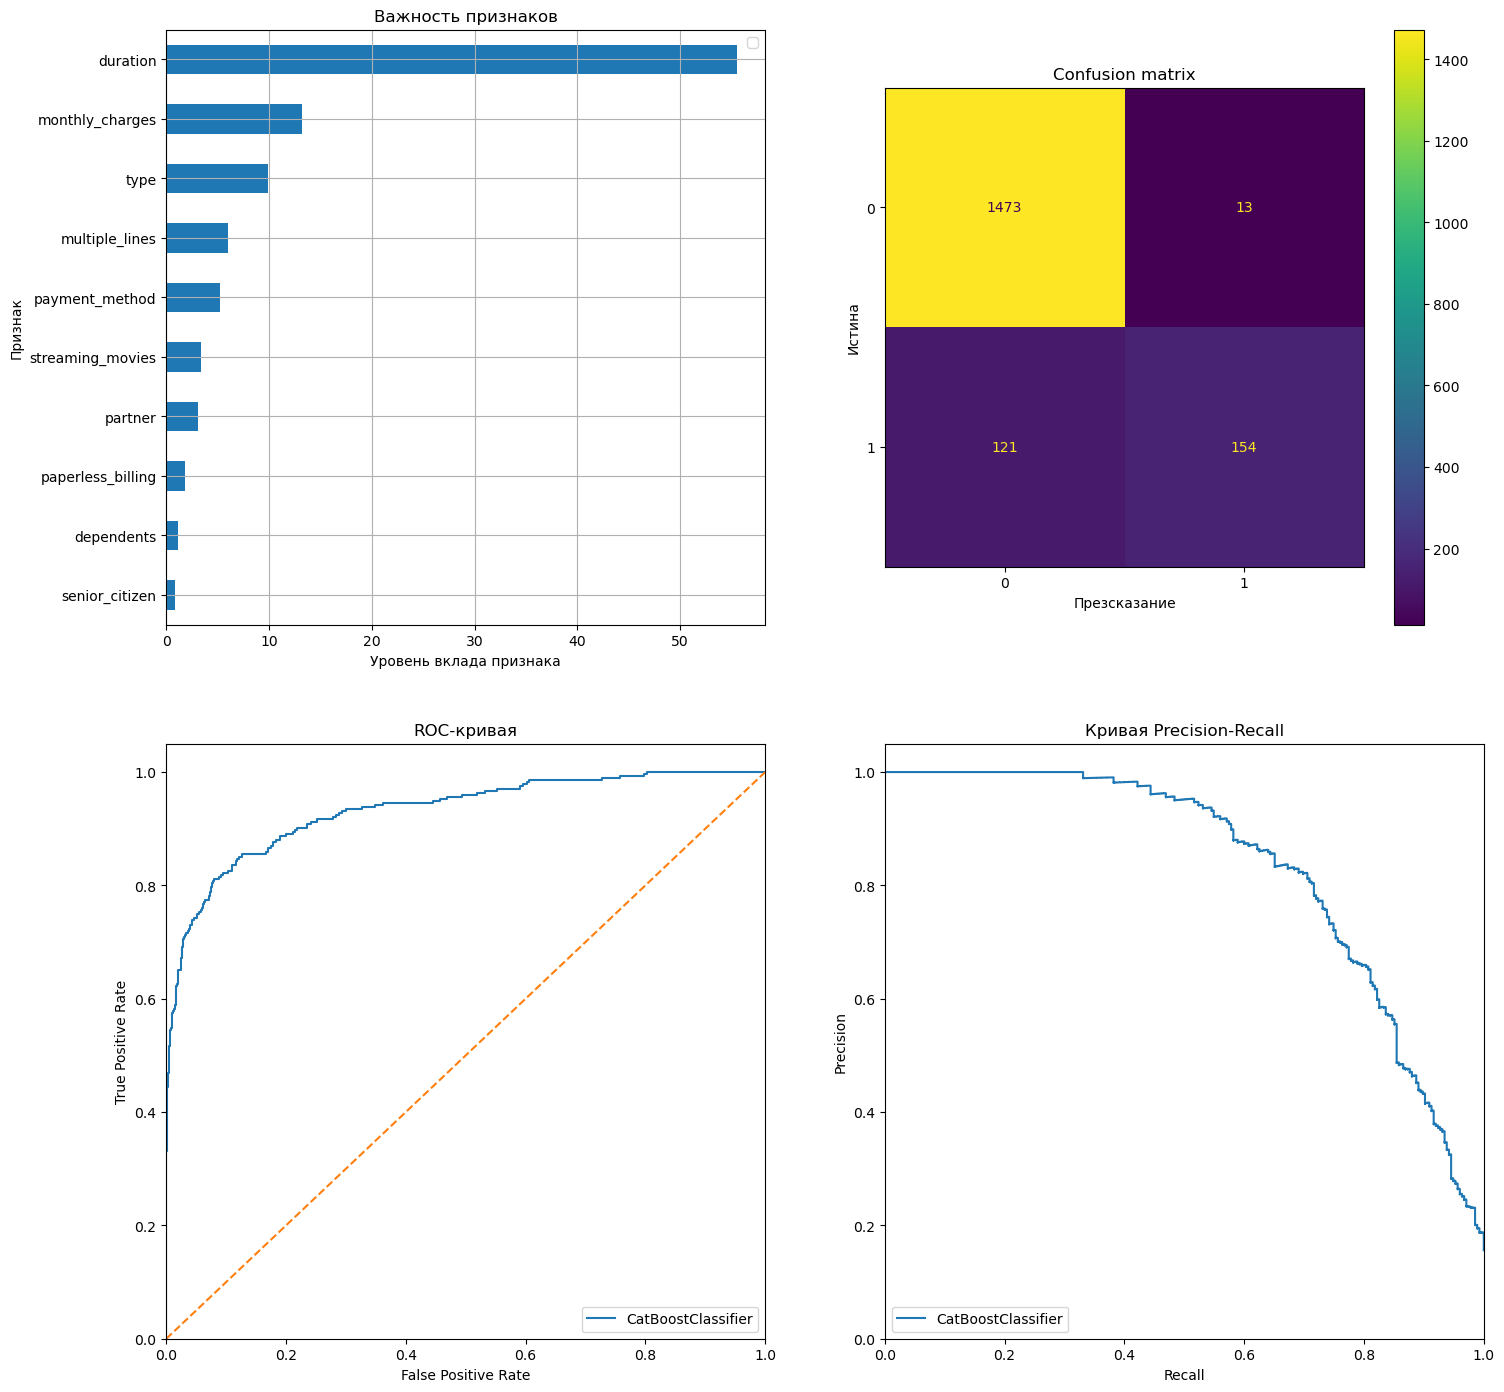

In [48]:
# Готовим данные для графиков
pred = grid_model_cat.predict(features_test)

fpr, tpr, thresholds = roc_curve(target_test, pred_proba[:, 1])
precision, recall, thresholds = precision_recall_curve(target_test, pred_proba[:, 1])
conf_matrix = confusion_matrix(target_test, pred)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 17))

# Рисуем рейтинг призанков
ax[0, 0].set_title('Важность признаков') 
pd.DataFrame(index=grid_model_cat.best_estimator_['transform'].get_feature_names_out(), \
          data=grid_model_cat.best_estimator_['classifier'].feature_importances_).sort_values(by=0).\
plot(kind='barh', ax=ax[0, 0], grid=True)
ax[0, 0].legend([])
ax[0, 0].set_xlabel('Уровень вклада признака')
ax[0, 0].set_ylabel('Признак')

# Рисуем матрицу ошибок
ax[0, 1].set_title('Сonfusion matrix') 
ConfusionMatrixDisplay(conf_matrix, display_labels=grid_model_cat.best_estimator_['classifier'].classes_).plot(ax=ax[0,1])
ax[0, 1].set_xlabel('Презсказание')
ax[0, 1].set_ylabel('Истина')

# Рисуем ROC-кривую
ax[1, 0].set_title('ROC-кривая') 
ax[1, 0].plot(fpr, tpr, linestyle='-', label='CatBoostClassifier')
ax[1, 0].plot([0, 1], [0, 1], linestyle='--')
ax[1, 0].set_xlim(0, 1)
ax[1, 0].set_ylim(0, 1.05)
ax[1, 0].legend(loc='lower right')
ax[1, 0].set_xlabel('False Positive Rate')
ax[1, 0].set_ylabel('True Positive Rate')

# Рисуем кривую Precision-Recall
ax[1, 1].set_title('Кривая Precision-Recall') 
ax[1, 1].step(recall, precision, where='post', label='CatBoostClassifier')
ax[1, 1].set_xlim(0, 1)
ax[1, 1].set_ylim(0, 1.05)
ax[1, 1].legend(loc='lower left')
ax[1, 1].set_xlabel('Recall')
ax[1, 1].set_ylabel('Precision');

По графикам можно сделать следующие выводы:

1. Работа с моделями не опровергла промежуточные выводы по портрету уходящего Клиента
2. Модель с трудом предсказывает то, что Клиент уйдет - у модели не очень хорошая полнота, recall = 0.6, чуть меньше половины Клиентов, которые собираются уйти, не получат промокод. С другой стороны, ненужные промокоды получит крайне малая доля Клиентов -- prediction = 0.93.  

В зависимости от целей Заказчика можно порекомендовать работу в сторону увеличения полноты. При условии, если затраты по удержанию Клиента малы в сравнении с привлечением нового, так как видно, что при увеличении recall выше, чем 0,65, точность обваливается драматично.

## Шаг 8. Общий вывод и рекомендации заказчику

В ходе исследования:

Построены и обучены на имеющихся данных модели, которые помогут предсказать разорвет ли клиент договор, исходя из:

- персональных данных Клиента
- информации о заключенных Контрактах
- подключенных тарифах и услугах

То есть:

1. Загружены дынные из четырех источников (Контракты, перс. данные, интернет-услуги и услуги телефонии)
2. Проведен исследовательский анализ и проведена предобработка данных
3. Данные были объединены в единый датафрейм
4. Проведены исследовательский анализ и предобработка данных объединённого датафрейма, составлен предварительный портрет Клиента, который готов к расторжению Контракта
5. Данные подготовлены к обучению
6. Проведено обучение четырех моделей
7. Среди моделей машинного обучения была выбрана лучшая, эта модель прошла успешное испытание на тестовых данных

На каждом этапе были оформлены промежуточные выводы

### Итоги исследования:

1. **Рекомендации в части данных**  
В ходе исследования для целей предсказаний оттока был определен необходимый и достаточный состав данных для каждого Клиента:

    - **Type** — тип оплаты: раз в год-два или ежемесячно
    - **PaperlessBilling** — электронный расчётный лист
    - **PaymentMethod** — тип платежа
    - **MonthlyCharges** — расходы за месяц
    - **SeniorCitizen** — является ли абонент пенсионером
    - **Partner** — есть ли у абонента супруг или супруга
    - **Dependents** — есть ли у абонента дети
    - **StreamingMovies** — каталог фильмов
    - **MultipleLines** — подключение телефона к нескольким линиям одновременно
    - **duration** — синтетический признак длительности Контракта, который получили из BeginDate и EndDate
Это значимо меньше, чем то разнообразие, которое мы получили на старте исследования. 
В остальном претензий к данным нет. Значения категориальных переменных выверены по справочникам, значимых пропусков, аномалий не было обнаружено.

2. **Результаты исследования**

* **Анализ данных**  
Основной интерес представляет анализ численных признаков

    - Распределение численных признаков без учета целевого признака
    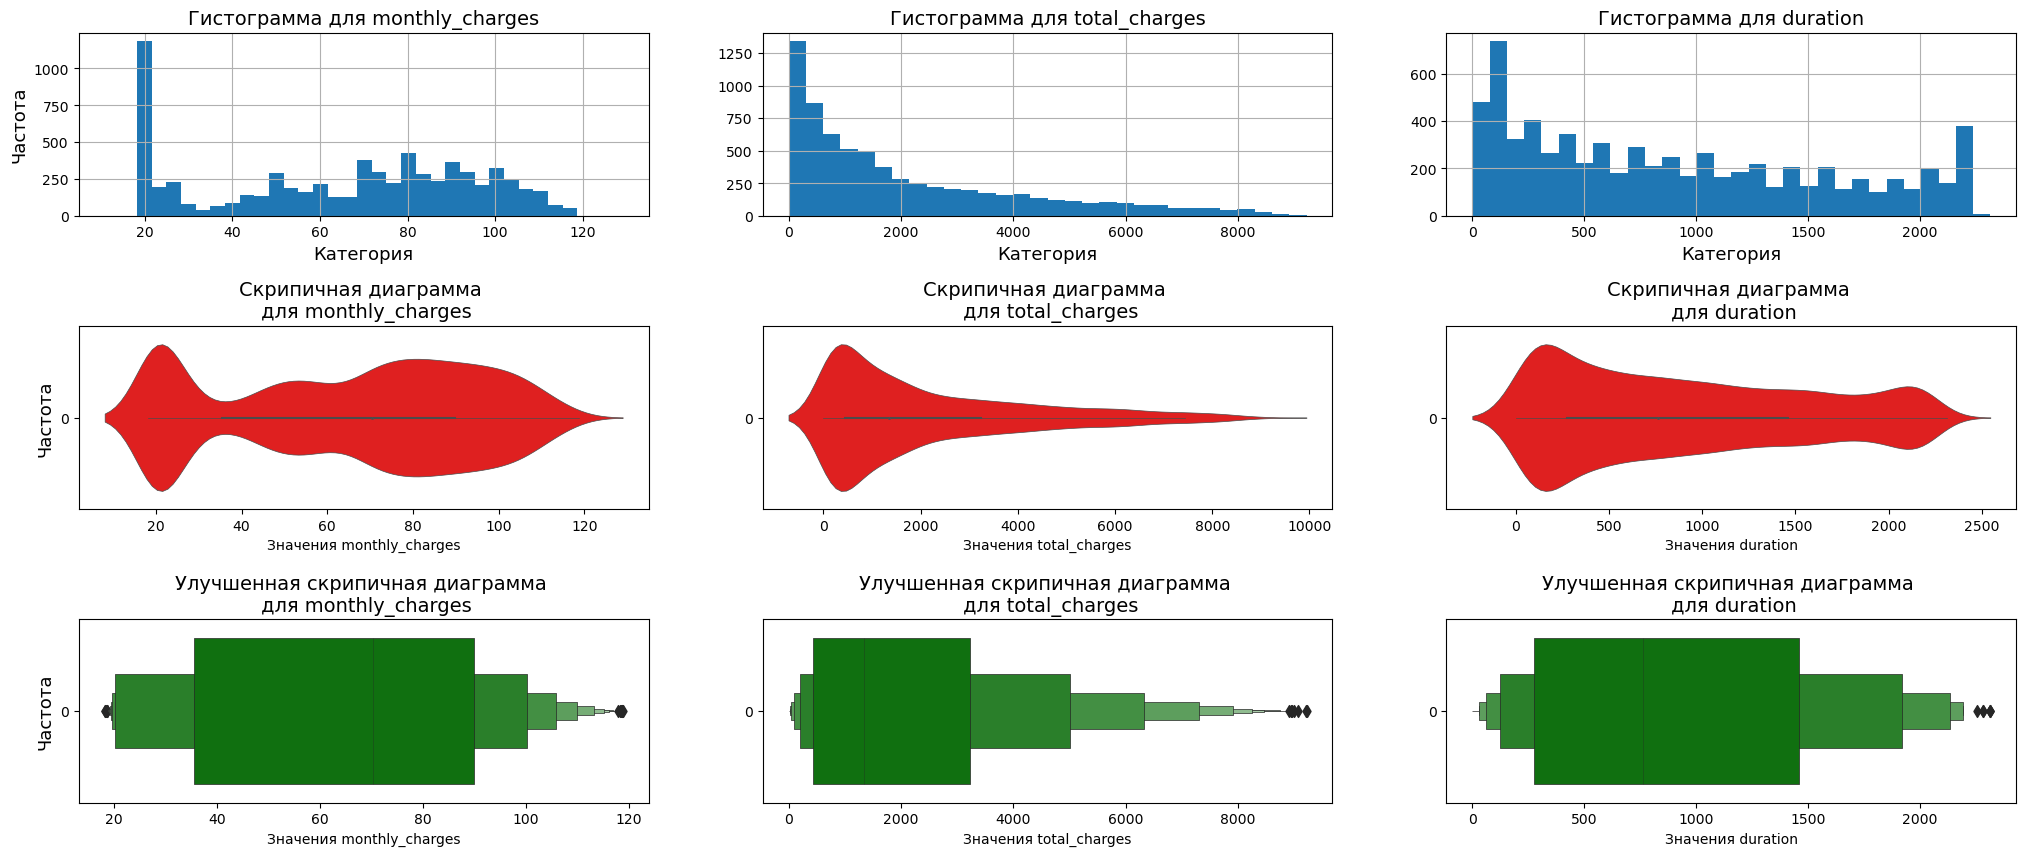
        * **monthly_charges** имеет пик в самом начале, до 30 долларов. Это пользователи, у которых подключет только телефон или только DSL интернет. Дальше плавный рост до 80 долларов и спад до 120 долларов. Выбросов сравнительно немного. Большая часть Клиентов платит от 35-и до 90 долларов в месяц. Горбы с шагом в пять долларов (их видно на детальном изучении пика около двадцати-тридцати долларов) можно объяснить тем, что у таких клиентов обычно по одной услуге, поэтому на ежемесячную стоимость сильно влияет фиксированное значение тарифа.
        * **total_charges и duration**, очевидно, взаимозависимы, однако, для duration есть пик после 2 200 дней, однако эти долгожители так же явно на общих выплатах не отражаются. Судя по всему, этот пик размазан наличием пользователей с небольшим monthly_charges. В остальном динамика схожа, пик на старте (до 500 долларов и 200 дней соответственно), потом плавный спад. Отмечу, что спад у duration не такой драматичный, если сравнивать с total_charges. Клиенты более равномерно распределены по продолжительности, чем по суммарным платежам. Отмечу также "гребенку" в duration. Судя по всему, тут виной то, что данные по датам округлены месяцем.    
    - Распределение численных признаков с учетом целевого признака
    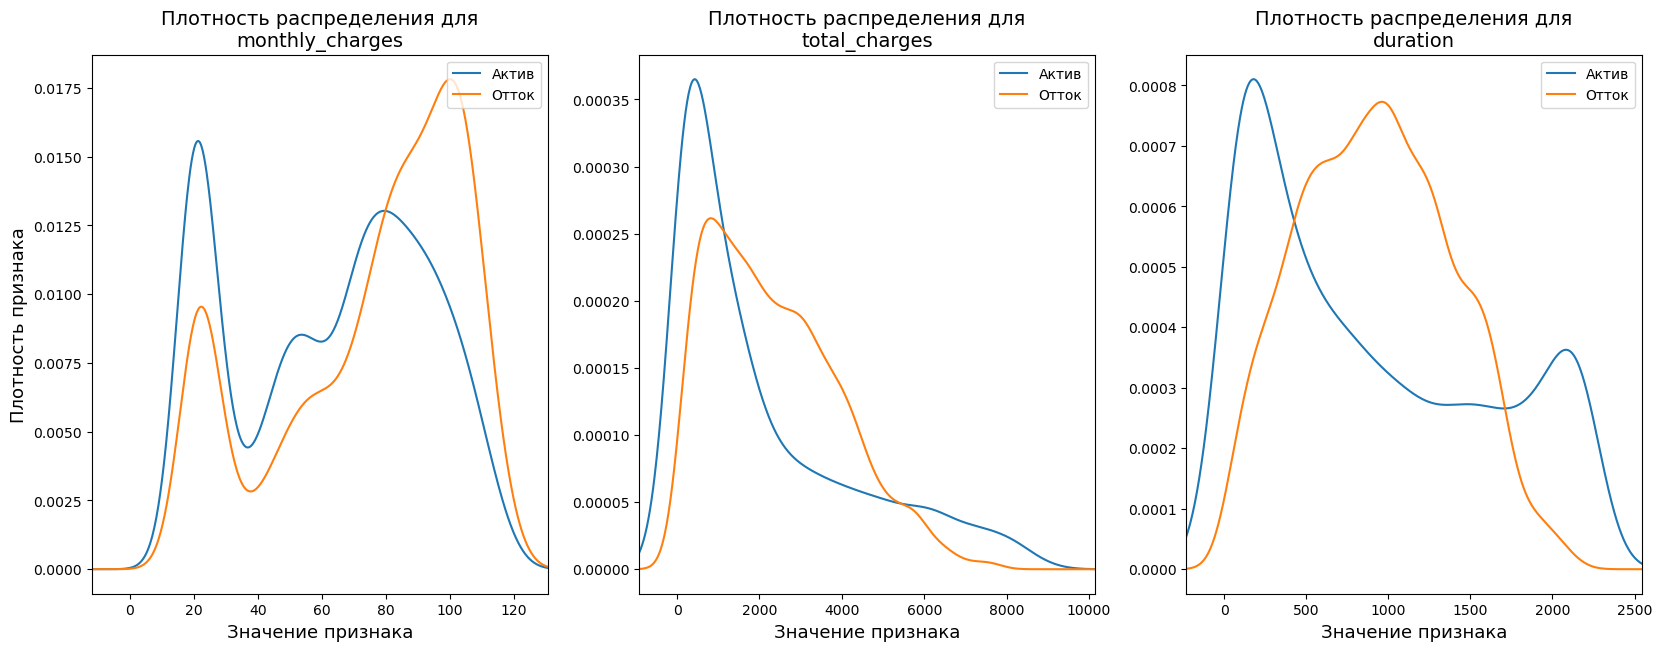
        * **monthly_charges** распределены принципиально иначе в зависимости от значения таргета. Судя по всему, Клиенты перед уходом платят больше. Этот признак, думаю, будет важен для обучения.
        * Кажется, что **total_charges** распределен похожим образом, но снижение плотности после тысячи долларов у ушедших более плавное
        * В **duration** -- самое интересное, на мой взгляд. Пик на сравнительно небольшой продолжительности -- около года, у активных. Судя по всему, "ТелеДом" год-полтора назад начал активно расширяться. Ушедшие былы Клиентами "ТелеДом"-а от полутора до четырех-пяти лет, в основном. Совсем уж долгожители не уходят. Тоже крайне важный признак.  
Если резюмировать и дополнить информацией, которую мы обнаружили, изучая целевые признаки, то можно увидеть **портрет потенциально готового к расторжению Контракта Клиента**:

1. Клиент уже некоторое время пользуется услугами Компании "ТелеДом", от полутора лет до четырех-пяти
2. У него подключено некоторое количество дополнительных услуг (или по телефонии, или по ШПД)
3. Ежемесячный платеж, вероятно, от шестидесяти долларов
4. Он не отдает особого предпочтения ежемесячному варианту оплаты
5. Очень не любит оплачивать услуги по почте
6. Если Клиент в браке, то вероятность ухода несколько повышается

* **Построение и тестирование модели**

Для исследования были выбраны четыре модели обучения:

    - LogisticRegression
    - DecisionTreeClassifier
    - CatBoostClassifier
    - LGBMClassifier
    
Среди них была выбрана модель 

**CatBoostClassifier**
* learning_rate == 0.121,
* iterations == 700,
* depth == 5

с самым лучшим значением показателя ROC AUC.
На тестовой выборке было достигнуто значение

$ROC AUC = 0.93,$

что значительно превышает целевое значение $ROC AUC \geq 0.85.$

Выбранная модель с трудом предсказывает то, что Клиент разорвет Контракт - у модели не очень хорошая полнота, recall = 0.6, чуть меньше половины Клиентов, которые собираются уйти, не получат промокод. С другой стороны, ненужные промокоды получит крайне малая доля Клиентов -- prediction = 0,93.  
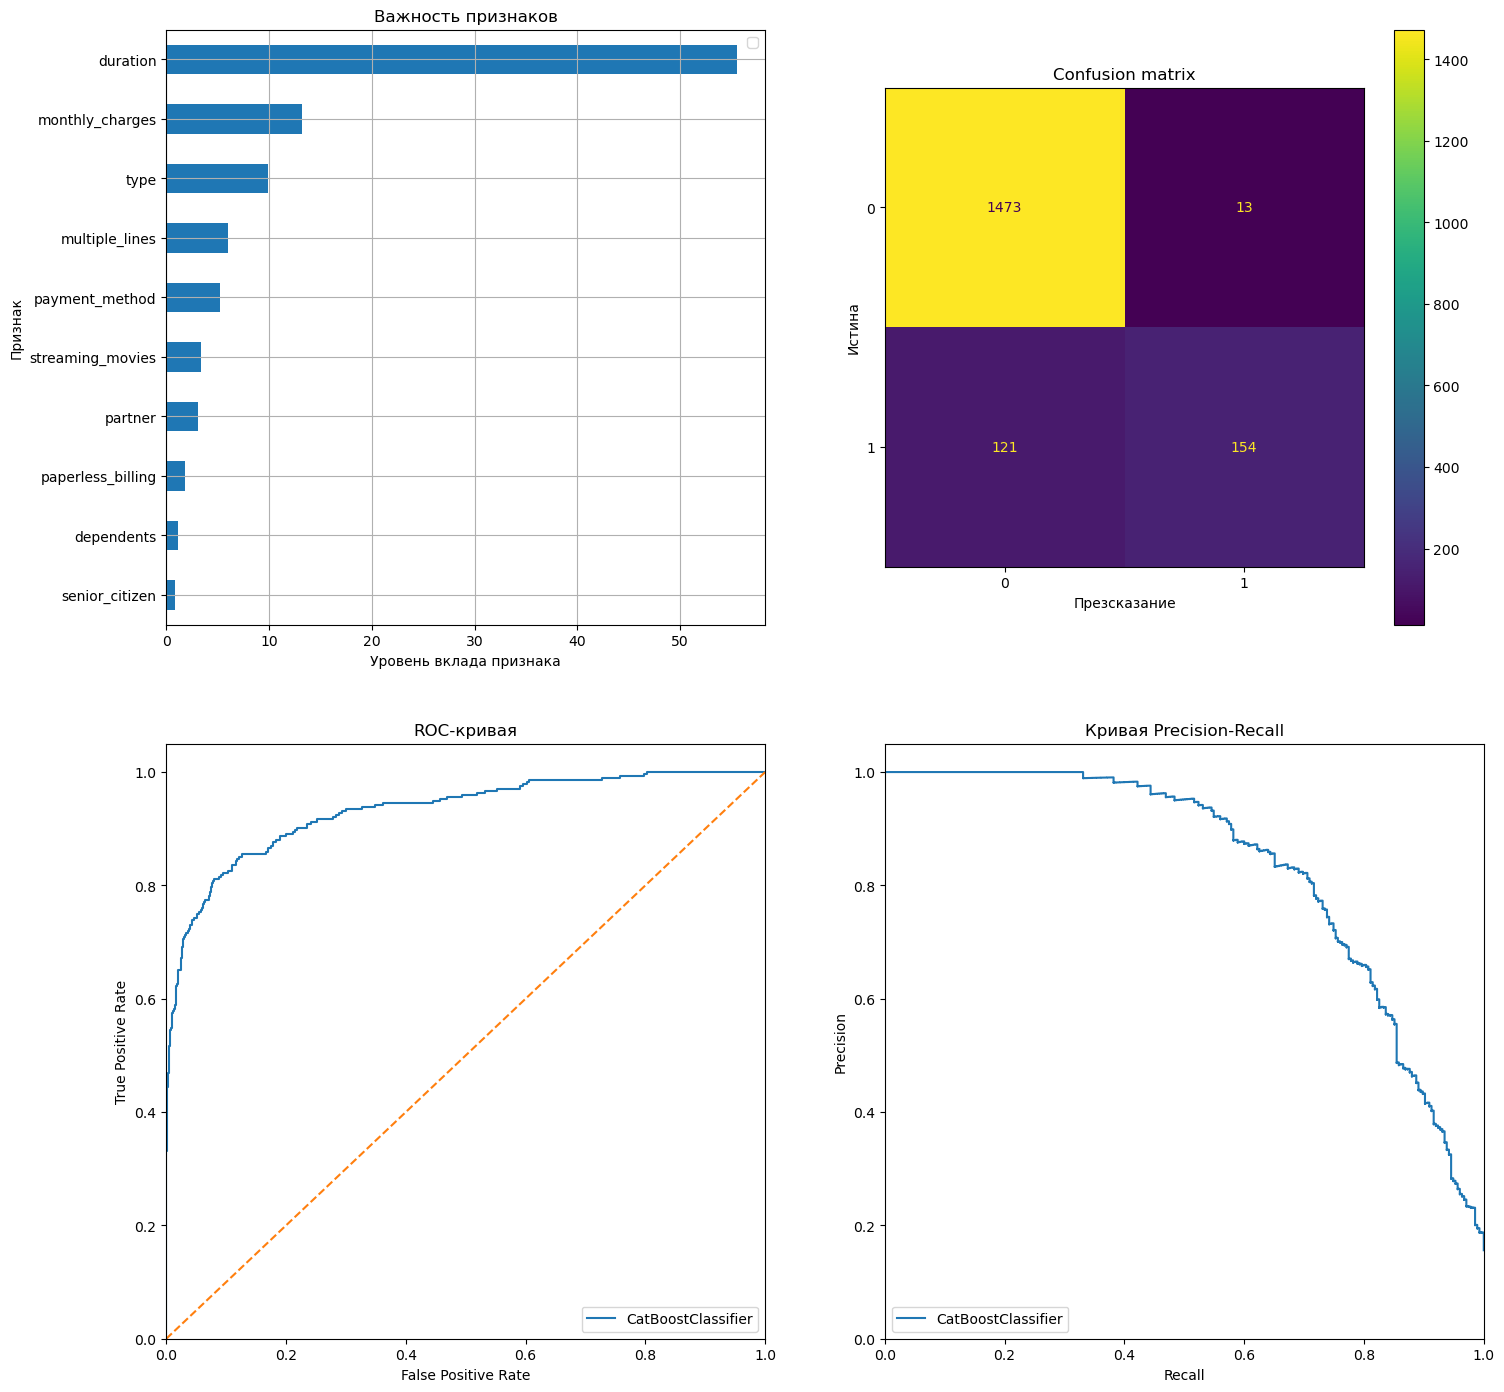
В зависимости от целей Заказчика можно порекомендовать работу в сторону увеличения полноты. При условии, если затраты по удержанию Клиента значительно малы в сравнении с привлечением нового, так как видно, что при увеличении recall выше, чем 0,65, точность обваливается драматично.